<img src="https://raw.githubusercontent.com/AmsterdamUMC/AmsterdamUMCdb/master/img/logo_amds.png" alt="Logo" style="width: 128px;"/>

# AmsterdamUMCdb Scientific Paper - Figure 3 - Timeline

Manuscript submitted for publication. Copyright &copy; 2003-2020 Amsterdam UMC - Amsterdam Medical Data Science

## Imports

In [1]:
%matplotlib inline
import amsterdamumcdb
import psycopg2
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import io
from IPython.display import display, HTML, Markdown, Image, SVG

from datetime import timedelta

import scipy
import scipy.signal


#small utility function to 'apply' a new index to a (grouped) dataframe
def reindex_by_date(df, index_start, index_end, interval, method=None, limit=None, fill_value=0):
    new_index = pd.date_range(index_start,index_end, freq=interval)
    return df.reindex(new_index, method=method, limit=limit, fill_value=fill_value)

## Display settings

In [2]:
#matplotlib settings for image size
#needs to be in a different cell from %matplotlib inline
plt.style.use('seaborn-darkgrid')
plt.rcParams['figure.dpi'] = 600
plt.rcParams['figure.figsize'] = [16, 12]

plt.rcParams['font.size'] = 10          # controls default text sizes
plt.rcParams['axes.titlesize'] = 'small'     # fontsize of the axes title
plt.rcParams['axes.labelsize'] = 'small'    # fontsize of the x and y labels
plt.rcParams['xtick.labelsize'] = 'x-small'    # fontsize of the tick labels
plt.rcParams['ytick.labelsize'] = 'x-small'    # fontsize of the tick labels
plt.rcParams['legend.fontsize'] =  'x-small'    # legend fontsize
plt.rcParams['figure.titlesize'] = 'small'  # fontsize of the figure title
plt.rcParams['axes.axisbelow'] = True # axis behind the graphs

pd.options.display.max_columns = None
pd.options.display.max_rows = None
pd.options.display.max_colwidth = 1000

## Connection settings

In [3]:
#Modify config.ini in the root folder of the repository to change the settings to connect to your postgreSQL database
import configparser
import os
config = configparser.ConfigParser()

if os.path.isfile('../config.ini'):
    config.read('../config.ini')
else:
    config.read('../config.SAMPLE.ini')

#Open a connection to the postgres database:
con = psycopg2.connect(database=config['psycopg2']['database'], 
                       user=config['psycopg2']['username'], password=config['psycopg2']['password'], 
                       host=config['psycopg2']['host'], port=config['psycopg2']['port'])
con.set_client_encoding('WIN1252') #Uses code page for Dutch accented characters.
con.set_session(autocommit=True)

cursor = con.cursor()
cursor.execute('SET SCHEMA \'amsterdamumcdb\''); #set search_path to amsterdamumcdb schema

## Create admissions table with diagnoses and interventions

In [4]:
sql_admissions_diagnoses = """
WITH diagnosis_groups AS (
SELECT admissionid,
        item, 
        value as diagnosis_group,
        CASE
            WHEN itemid = 13110 AND valueid BETWEEN 1 AND 3 THEN 1 --D_Hoofdgroep
            WHEN itemid = 16651 AND valueid BETWEEN 7 AND 9 THEN 1 --DMC_Hoofdgroep
            WHEN itemid = 16997 AND valueid BETWEEN 11 AND 20 THEN 1 --APACHE IV Groepen
            WHEN itemid = 18588 AND valueid BETWEEN 1 AND 7 THEN 1 --Apache II Hoofdgroep
            ELSE 0
        END AS surgical,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY measuredat DESC) AS rownum
    FROM listitems
    WHERE itemid IN (
        --MAIN GROUP - LEVEL 0
        13110, --D_Hoofdgroep
        16651 --DMC_Hoofdgroep, Medium Care
    )
),diagnosis_subgroups AS (
SELECT admissionid,
        item, 
        value as diagnosis_subgroup,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY measuredat DESC) AS rownum
    FROM listitems
    WHERE itemid IN (
        --SUB GROUP - LEVEL 1
        13111, --D_Subgroep_Thoraxchirurgie
        16669, --DMC_Subgroep_Thoraxchirurgie
        13112, --D_Subgroep_Algemene chirurgie
        16665, --DMC_Subgroep_Algemene chirurgie
        13113, --D_Subgroep_Neurochirurgie
        16667, --DMC_Subgroep_Neurochirurgie
        13114, --D_Subgroep_Neurologie
        16668, --DMC_Subgroep_Neurologie
        13115, --D_Subgroep_Interne geneeskunde
        16666 --DMC_Subgroep_Interne geneeskunde
    )
), diagnoses AS (
SELECT admissionid,
        item, 
        value as diagnosis,
        ROW_NUMBER() OVER(PARTITION BY admissionid
        ORDER BY measuredat DESC) AS rownum
FROM listitems
WHERE itemid IN (
        -- Diagnosis - LEVEL 2
        --SURGICAL
        13116, --D_Thoraxchirurgie_CABG en Klepchirurgie
        16671, --DMC_Thoraxchirurgie_CABG en Klepchirurgie
        13117, --D_Thoraxchirurgie_Cardio anders
        16672, --DMC_Thoraxchirurgie_Cardio anders
        13118, --D_Thoraxchirurgie_Aorta chirurgie
        16670, --DMC_Thoraxchirurgie_Aorta chirurgie
        13119, --D_Thoraxchirurgie_Pulmonale chirurgie
        16673, --DMC_Thoraxchirurgie_Pulmonale chirurgie
        13141, --D_Algemene chirurgie_Algemeen   
        16642, --DMC_Algemene chirurgie_Algemeen
        13121, --D_Algemene chirurgie_Buikchirurgie
        16643, --DMC_Algemene chirurgie_Buikchirurgie
        13123, --D_Algemene chirurgie_Endocrinologische chirurgie
        16644, --DMC_Algemene chirurgie_Endocrinologische chirurgie
        13145, --D_Algemene chirurgie_KNO/Overige
        16645, --DMC_Algemene chirurgie_KNO/Overige
        13125, --D_Algemene chirurgie_Orthopedische chirurgie
        16646, --DMC_Algemene chirurgie_Orthopedische chirurgie
        13122, --D_Algemene chirurgie_Transplantatie chirurgie
        16647, --DMC_Algemene chirurgie_Transplantatie chirurgie
        13124, --D_Algemene chirurgie_Trauma
        16648, --DMC_Algemene chirurgie_Trauma
        13126, --D_Algemene chirurgie_Urogenitaal
        16649, --DMC_Algemene chirurgie_Urogenitaal
        13120, --D_Algemene chirurgie_Vaatchirurgie
        16650, --DMC_Algemene chirurgie_Vaatchirurgie
        13128, --D_Neurochirurgie _Vasculair chirurgisch
        16661, --DMC_Neurochirurgie _Vasculair chirurgisch
        13129, --D_Neurochirurgie _Tumor chirurgie
        16660, --DMC_Neurochirurgie _Tumor chirurgie
        13130, --D_Neurochirurgie_Overige
        16662, --DMC_Neurochirurgie_Overige

        --MEDICAL
        13133, --D_Interne Geneeskunde_Cardiovasculair
        16653, --DMC_Interne Geneeskunde_Cardiovasculair
        13134, --D_Interne Geneeskunde_Pulmonaal
        16658, --DMC_Interne Geneeskunde_Pulmonaal
        13135, --D_Interne Geneeskunde_Abdominaal
        16652, --DMC_Interne Geneeskunde_Abdominaal
        13136, --D_Interne Geneeskunde_Infectieziekten
        16655, --DMC_Interne Geneeskunde_Infectieziekten
        13137, --D_Interne Geneeskunde_Metabool
        16656, --DMC_Interne Geneeskunde_Metabool
        13138, --D_Interne Geneeskunde_Renaal
        16659, --DMC_Interne Geneeskunde_Renaal
        13139, --D_Interne Geneeskunde_Hematologisch
        16654, --DMC_Interne Geneeskunde_Hematologisch
        13140, --D_Interne Geneeskunde_Overige
        16657, --DMC_Interne Geneeskunde_Overige
        13131, --D_Neurologie_Vasculair neurologisch
        16664, --DMC_Neurologie_Vasculair neurologisch
        13132, --D_Neurologie_Overige
        16663, --DMC_Neurologie_Overige 
        13127 --D_KNO/Overige
        )
),
interventions AS (
    SELECT 
        admissionid, 
        CASE
            WHEN SUM((item ILIKE \'%ECMO%\')::INT) > 0 THEN TRUE 
            ELSE FALSE
        END AS ecmo,
        CASE
            WHEN SUM((item ILIKE \'%CVVH%\')::INT) > 0 THEN TRUE 
            ELSE FALSE
        END AS crrt,
        CASE
            WHEN SUM((item ILIKE \'%SWAN%\')::INT) > 0 THEN TRUE
            ELSE FALSE
        END AS pac
    FROM processitems
    GROUP BY admissionid
)
SELECT
    a.admissionid,
    a.admissioncount,
    a.location,
    a.urgency,
    a.origin,
    a.admittedat,
    a.admissionyeargroup,
    a.dischargedat,
    a.lengthofstay,
    a.destination,
    a.gender,
    a.agegroup,
    a.dateofdeath,
    a.weightgroup,
    a.heightgroup,
    a.specialty,
    diagnoses.diagnosis,
    diagnosis_subgroups.diagnosis_subgroup,
    diagnosis_groups.diagnosis_group,
    i.pac,
    i.ecmo,
    i.crrt
    FROM admissions a
LEFT JOIN diagnoses ON a.admissionid = diagnoses.admissionid
LEFT JOIN diagnosis_subgroups ON a.admissionid = diagnosis_subgroups.admissionid
LEFT JOIN diagnosis_groups ON a.admissionid = diagnosis_groups.admissionid         
LEFT JOIN interventions i ON a.admissionid = i.admissionid
WHERE 
    (diagnoses.rownum = 1 OR diagnoses.rownum IS NULL)
    AND (diagnosis_subgroups.rownum = 1 OR diagnosis_subgroups.rownum IS NULL)
    AND (diagnosis_groups.rownum = 1 OR diagnosis_groups.rownum IS NULL) --only last updated record
    
    --uncomment to preselect patients based on specific criteria
    --AND crrt
    --AND pac
    --AND admissionyeargroup = '2010-2016' 
    --AND urgency = B'1'
    --AND NOT destination = 'Overleden' 
    --AND lengthofstay < 30*24
"""
admissions_diagnoses = pd.read_sql(sql_admissions_diagnoses,con)
admissions_diagnoses.head(5)

admissionid  admissioncount location urgency  \
0            0               1       IC       0   
1            1               1       IC       0   
2            2               1       IC       1   
3            3               1       IC       0   
4            4               1    IC&MC       0   

                                   origin  admittedat admissionyeargroup  \
0                                    None           0          2003-2009   
1                                    None           0          2010-2016   
2  Eerste Hulp afdeling zelfde ziekenhuis           0          2010-2016   
3                                    None           0          2003-2009   
4      Verpleegafdeling zelfde ziekenhuis           0          2010-2016   

   dischargedat  lengthofstay destination gender agegroup  dateofdeath  \
0     148800000            42          16  Vrouw      80+          NaN   
1      96120000            26          15    Man    60-69          NaN   
2      84240000            23          15    Man    60-69          NaN   
3      84900000            23          14    Man    50-59          NaN   
4     180900000            50          19    Man    70-79          NaN   

  weightgroup heightgroup        specialty                    diagnosis  \
0       60-69     160-169  Cardiochirurgie                         CABG   
1       70-79     170-179  Cardiochirurgie                      Bentall   
2       90-99     180-189  Cardiochirurgie  Gecombineerde hartchirurgie   
3       90-99     180-189  Cardiochirurgie                         None   
4       70-79     170-179  Cardiochirurgie                         CABG   

      diagnosis_subgroup  diagnosis_group   pac   ecmo   crrt  
0  CABG en Klepchirurgie  Thoraxchirurgie  True  False  False  
1        Aorta chirurgie  Thoraxchirurgie  True  False  False  
2  CABG en Klepchirurgie  Thoraxchirurgie  True  False  False  
3                   None             None  True  False  False  
4  CABG en Klepchirurgie  Thoraxchirurgie  True  False  False

## Create the full composite time line

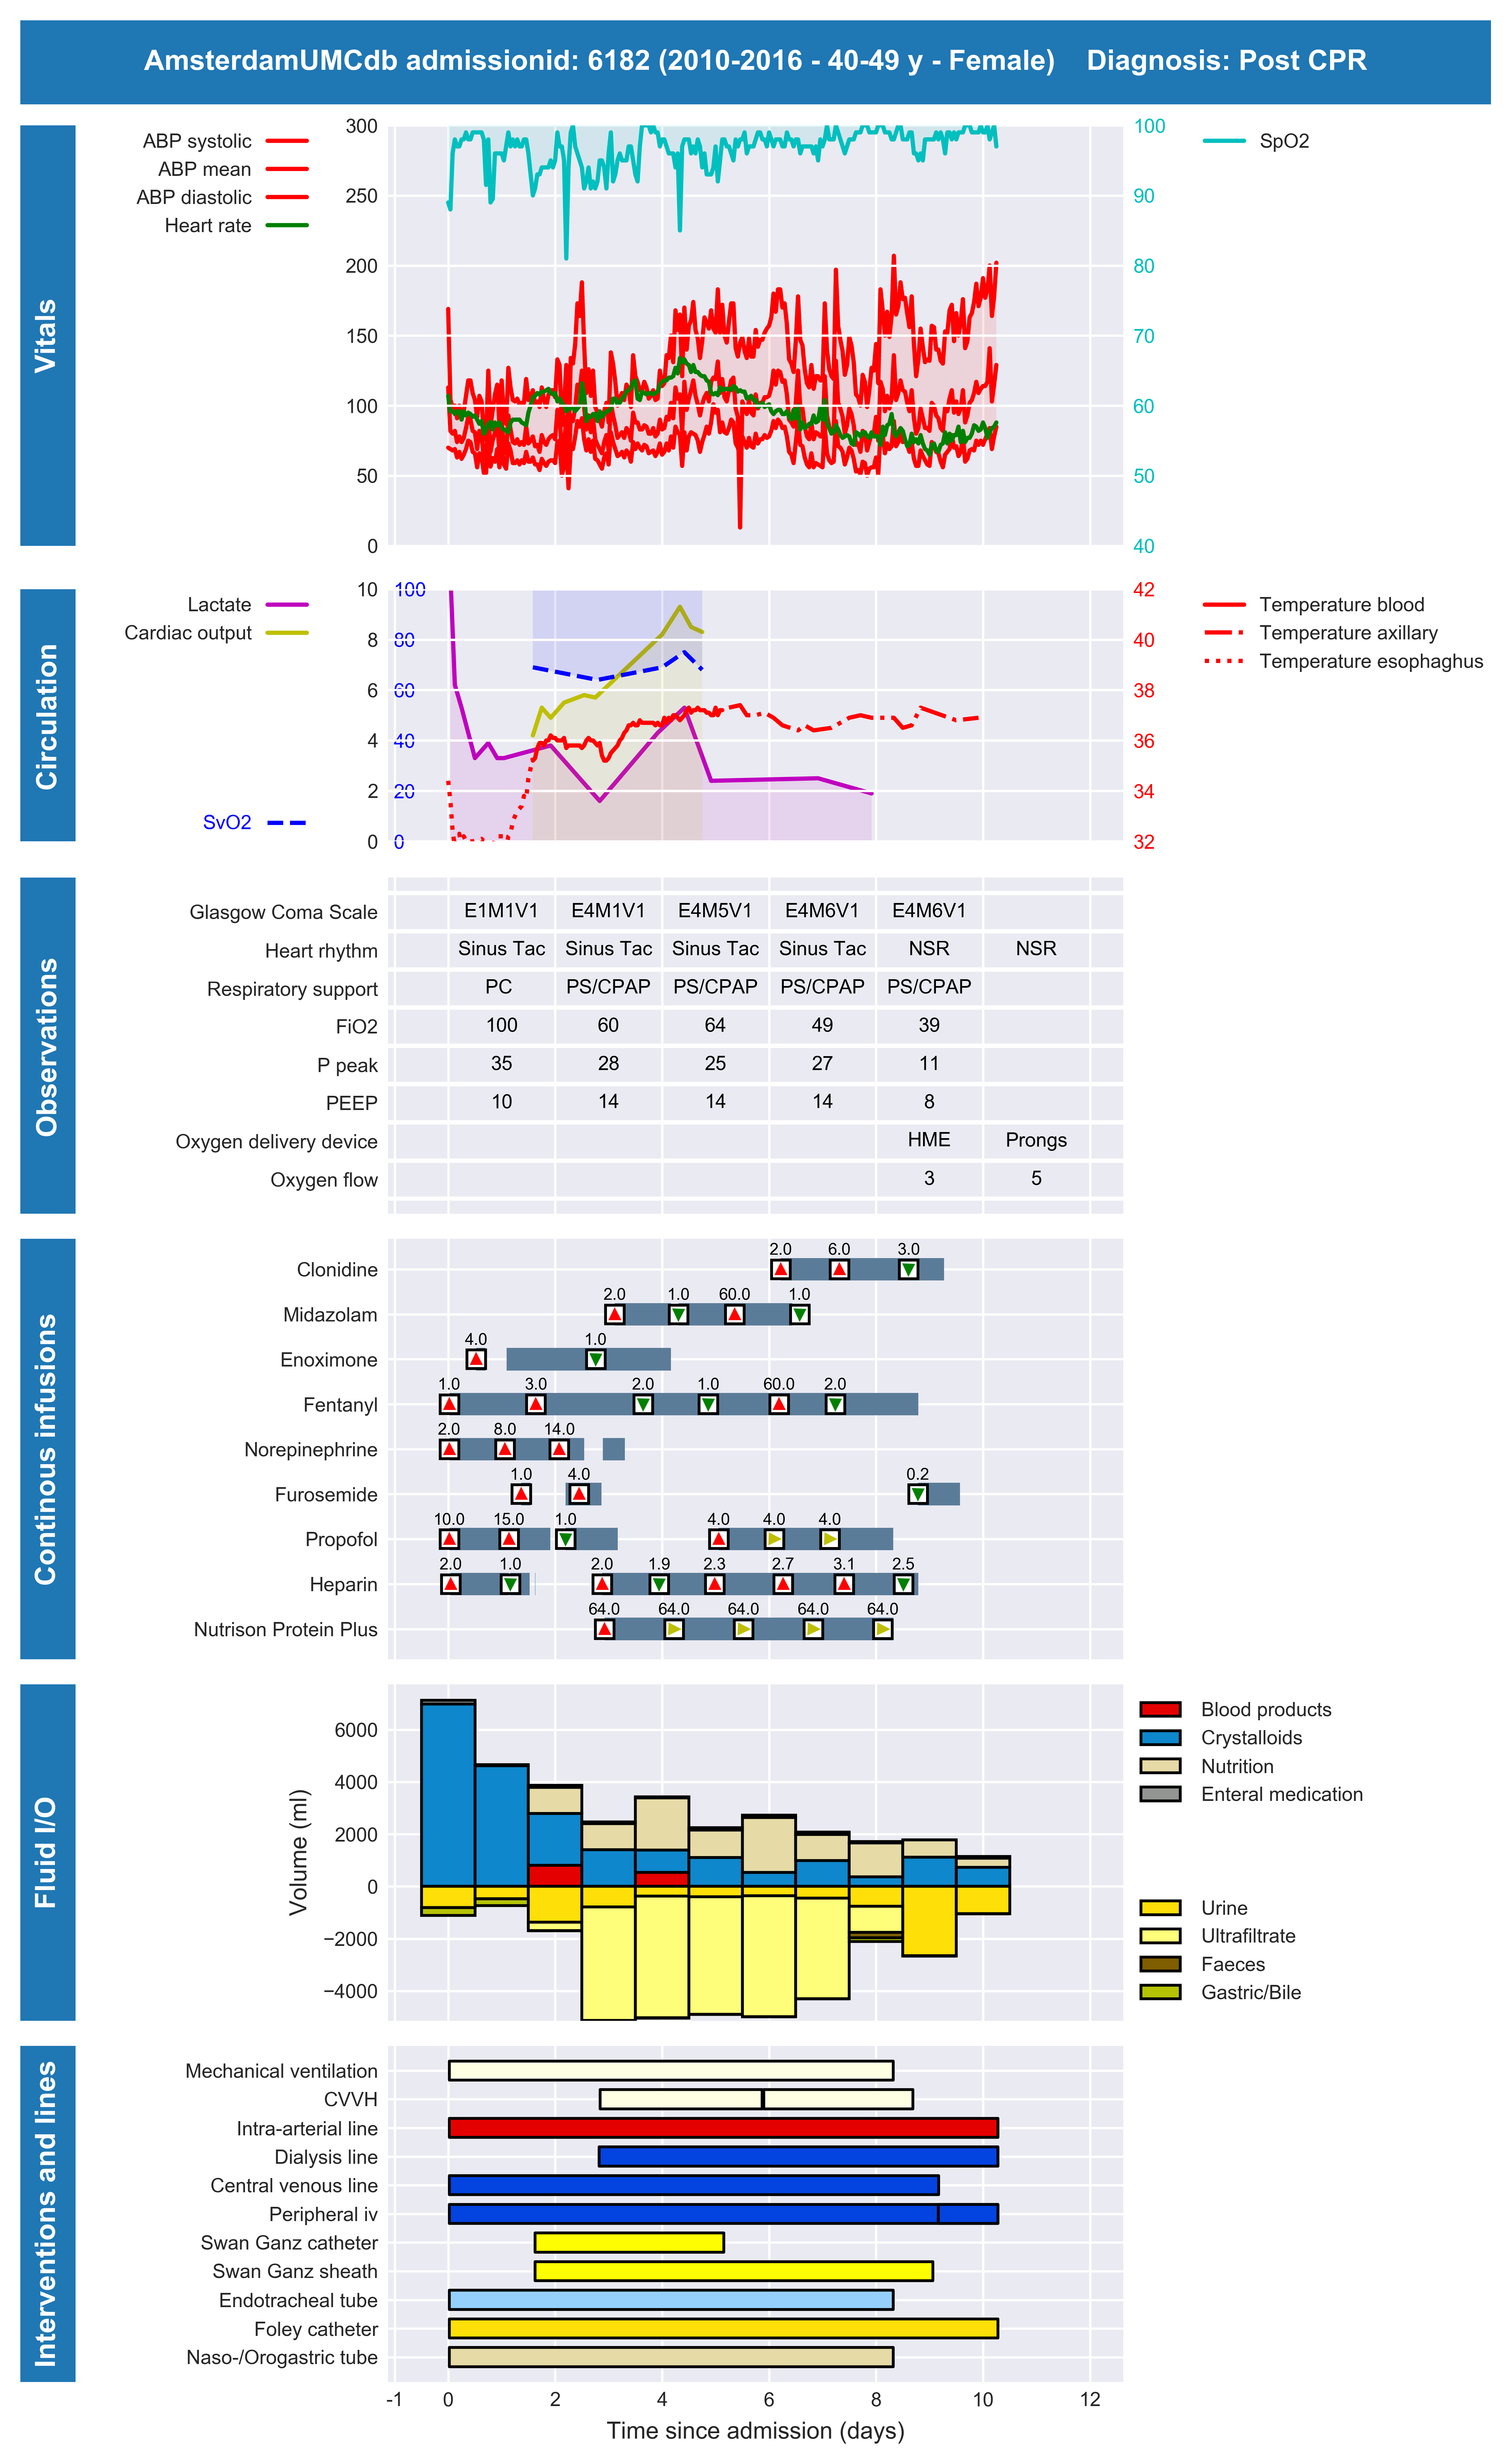

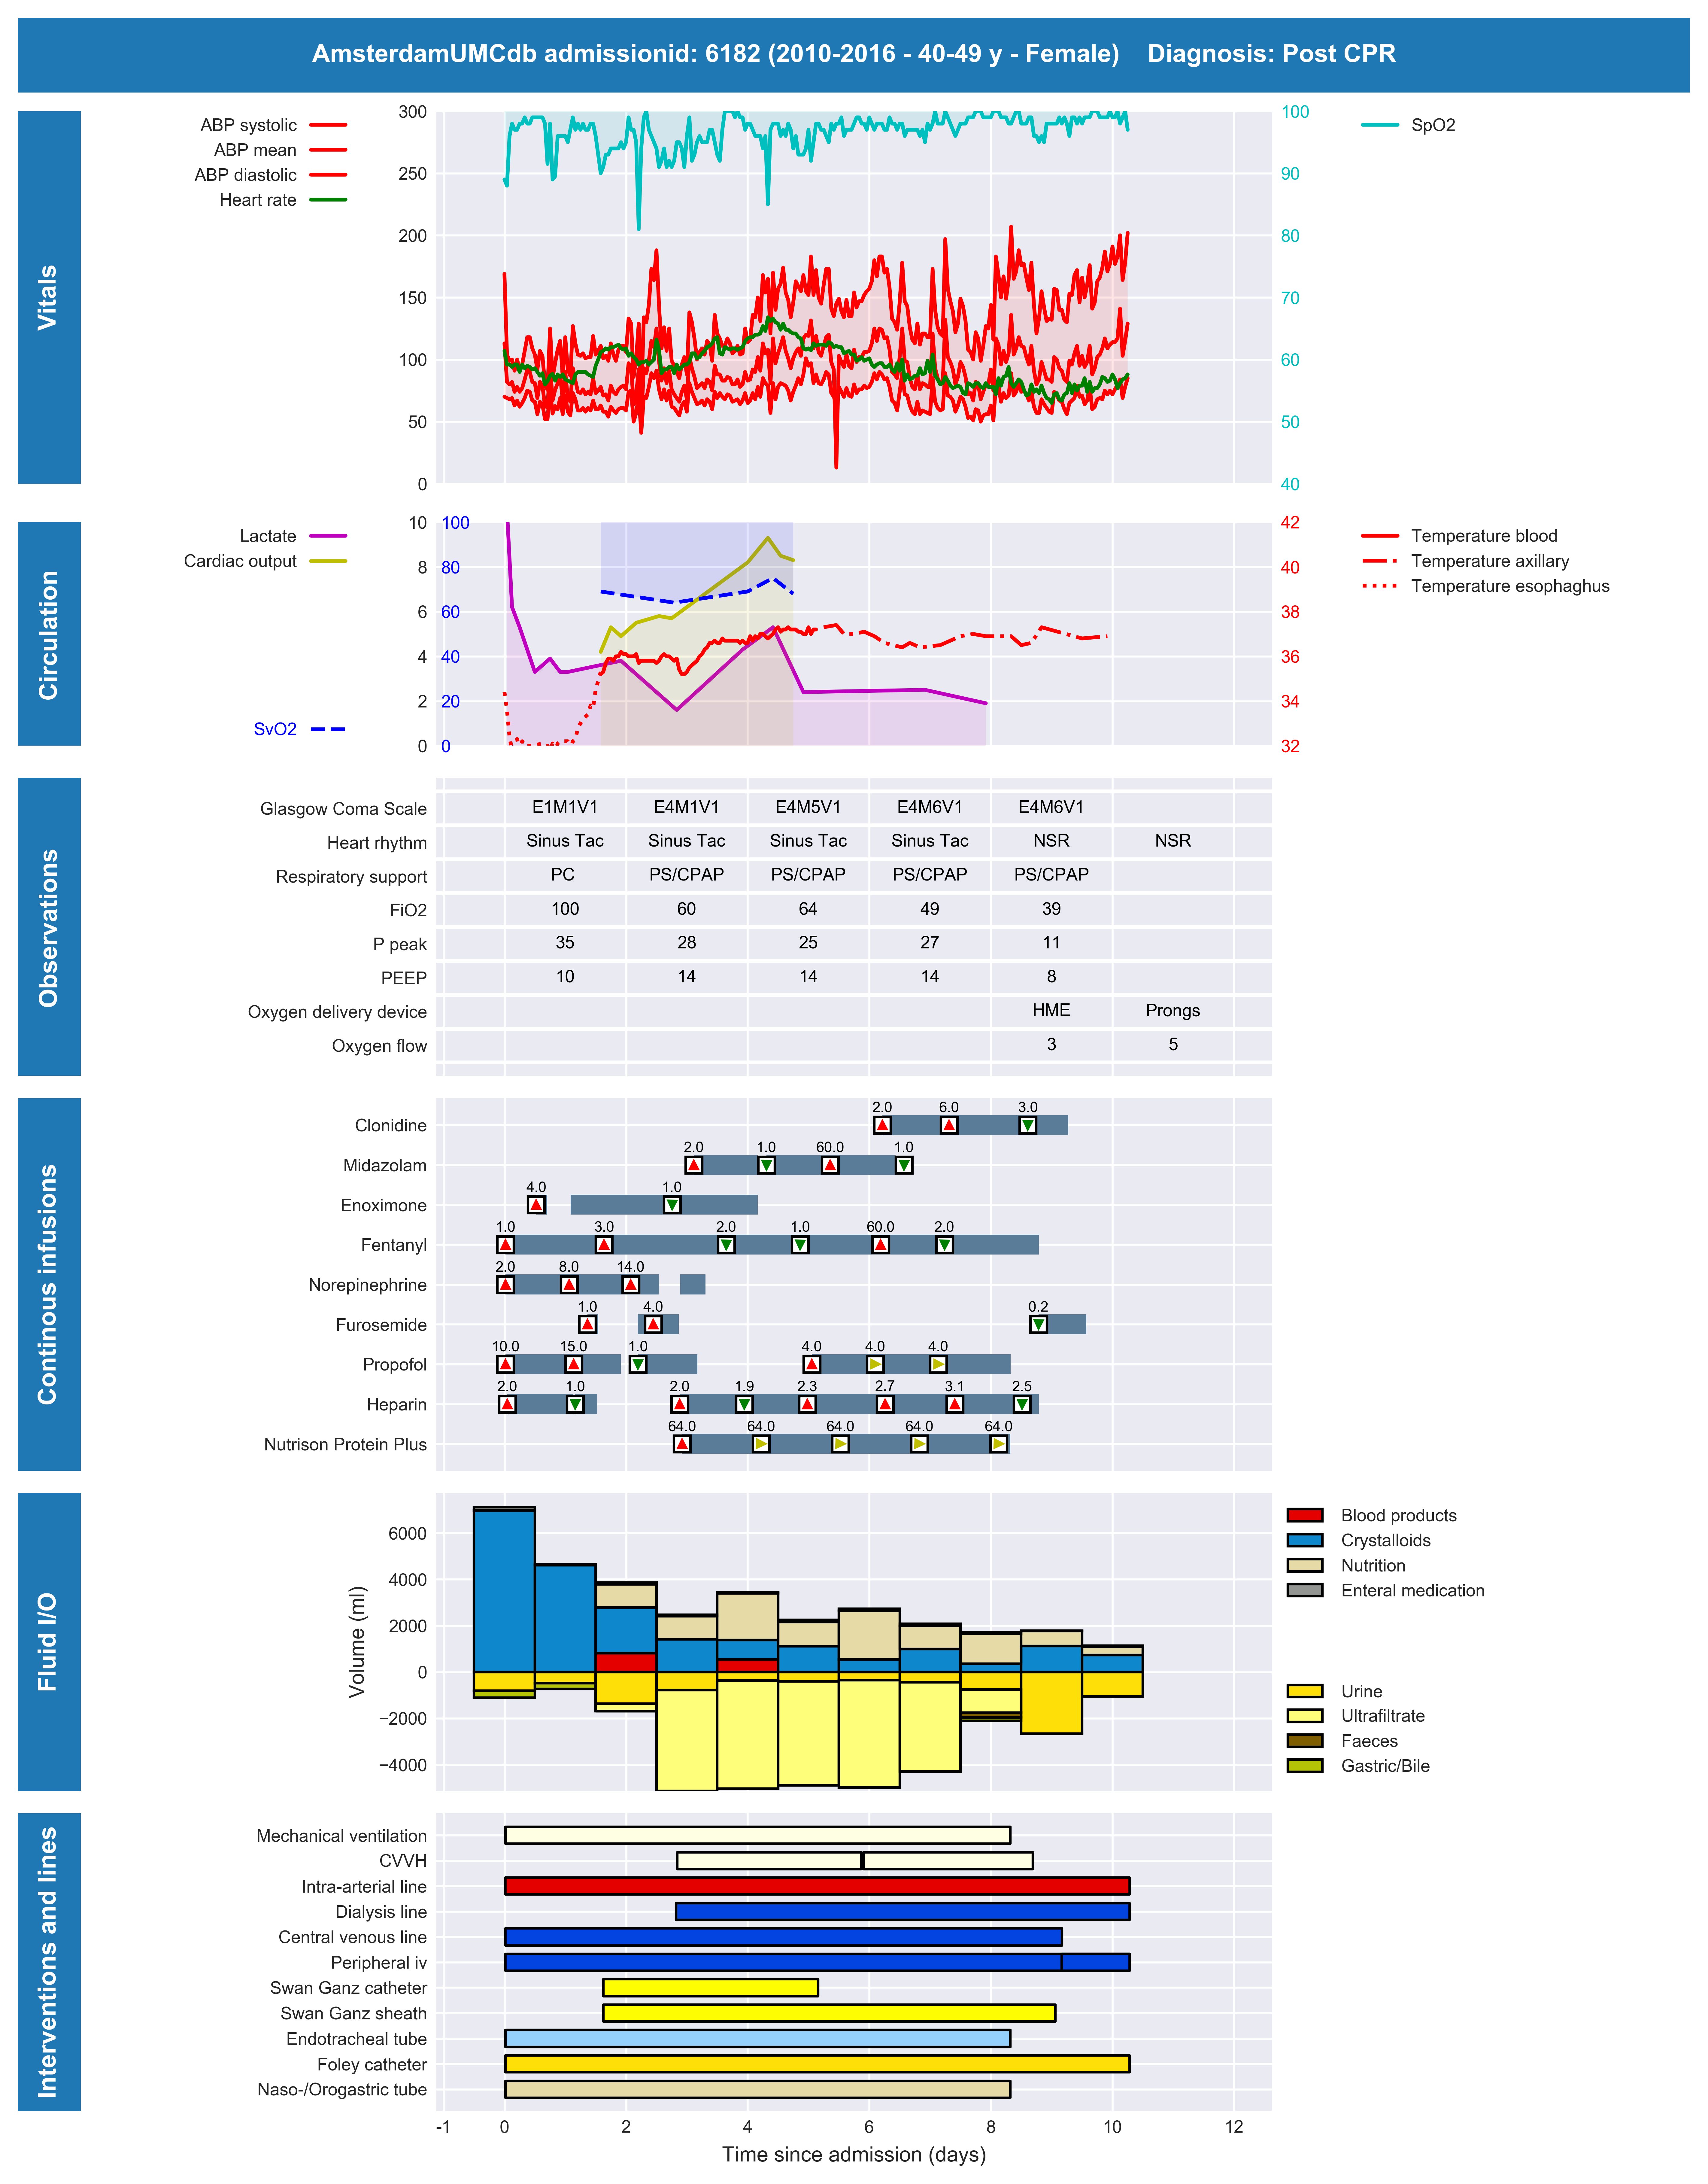

In [5]:
#admissionid = 3441 #ECMO
admissionid = 6182 #post cardiac arrest

#admission time stored as matplotlib datenum:
mpl_admittedat = mpl.dates.epoch2num(admissions_diagnoses.loc[admissions_diagnoses['admissionid'] == admissionid, 
                                                              'admittedat'].values[0])

scale_factor = .3

fluids_interval = timedelta(hours=24)
flowsheet_interval = timedelta(hours=48)
signals_interval = timedelta(minutes=60)
drugs_info_interval = timedelta(hours=24)

def add_section_box(axis, title):
#adds section headers
    x = -0.5
    y = 0
    width = 0.075
    height = 1

    rect = Rectangle((x, y), width, height, transform=axis.transAxes, clip_on=False)
    axis.add_patch(rect)
    axis.text(s=title, x=(x + width/2), y=height/2, rotation=90, transform=axis.transAxes, 
              color='white', fontweight='bold', horizontalalignment='center', verticalalignment='center')
    
def twinax_match_ticks(ax, twin):
    
    #get info of primary axis
    ylim1 = ax.get_ylim()
    len1 = ylim1[1]-ylim1[0]
    yticks1 = ax.get_yticks()
    
    #gets the distances between ticks for the primary axis
    rel_dist = [(y-ylim1[0])/len1 for y in yticks1] 
    
    #gets info of secondary axis
    ylim2 = twin.get_ylim()
    len2 = ylim2[1]-ylim2[0]
    
    #sets the same distances for the ticks of the twin axis
    yticks2 = [ry*len2+ylim2[0] for ry in rel_dist] 
    
    #change the ticks of the twin axis (secondary y-axis)
    twin.set_yticks(yticks2) #changes the thicks
    twin.set_ylim(ylim2) #restores the previous limits
    twin.grid(False) #hides the unneccessary lines

#defines all subplots here for sharing the x-axis among them
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex=True, figsize=(8,12), constrained_layout=True, 
                                              gridspec_kw={'height_ratios': [1.25,0.75,1,1.25,1,1]})
   
#date format for x-axes
ax1.xaxis_date()
ax2.xaxis_date()
ax3.xaxis_date()
ax4.xaxis_date()
ax5.xaxis_date()
ax6.xaxis_date()

#######################################
# Vitals
#######################################
ax1_twin = ax1.twinx()  # second axis sharing x-axis for SpO2
ax2_twin = ax2.twinx() #second axis sharing x-axis for SvO2
ax2_twin_right = ax2.twinx() #second axis for temperatures

sql_signals = """
SELECT 
    n.measuredat AS time,
    n.value,
    n.itemid,
    n.item,
    n.unit
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE  
    n.admissionid = {admissionid}
    AND n.measuredat >= a.admittedat AND n.measuredat <= a.dischargedat
    --vital signs
    AND (
            n.itemid IN (
                --vitals
                6640, --Heart rate 
                6642, -- mABP
                6641, -- sABP
                6643,  -- dABP
                6709, -- SpO2
                
                --circulation
                6656, --Cardiac Output
                10053, --Lactaat (bloed)
                
                --temperatures
                8658, --Temp Bloed
                8659, --Temperatuur Perifeer 2
                8662, --Temperatuur Perifeer 1
                13058, --Temp Rectaal
                13059, --Temp Lies
                13060, --Temp Axillair
                13061, --Temp Oraal
                13062, --Temp Oor
                13063, --Temp Huid
                13952, --Temp Blaas
                16110 --Temp Oesophagus
            )
    )

UNION
--query for getting (mixed/central) venous samples
SELECT
    n.measuredat AS time,
    CASE 
        WHEN n.itemid = 12311 THEN
            CASE
                WHEN n.value <= 1 THEN n.value*100
                ELSE n.value
            END
        ELSE n.value        
    END AS value,
    n.itemid,
    CASE 
        WHEN n.itemid = 12311 THEN 'SvO2'
        ELSE n.item
    END AS item, 
    n.unit
FROM numericitems n
LEFT JOIN freetextitems f ON
    n.admissionid = f.admissionid
    AND n.measuredat = f.measuredat
    AND f.itemid = 11646 --Afname (bloed): source of specimen
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE 
    n.admissionid = {admissionid}
    AND n.measuredat >= a.admittedat AND n.measuredat <= a.dischargedat
    AND n.itemid IN (
        12311 --Saturatie (bloed)
    )
    AND LOWER(f.value) LIKE '%ven%' -- source is (mixed) venous
ORDER BY time

""".format(admissionid=admissionid)
signals = pd.read_sql(sql_signals,con)
signals['time'] = pd.to_datetime(signals['time'], unit='ms')

#downsample to 1-hour for readability of device data
signals = signals.set_index(['time', 'item', 'itemid','unit']).groupby(
    ['item','itemid','unit']).resample('1H', level=0).mean().reset_index().dropna()

#reasonable physiological limits for axes
ax1.set_ylim(top=300,bottom=0) #vitals
ax1_twin.set_ylim(top=100,bottom=40) #oxygenation
ax2.set_ylim(top=10,bottom=0) #circulation
ax2_twin.set_ylim(top=100,bottom=0) #SvO2
ax2_twin_right.set_ylim(top=42,bottom=32) #temperature

#formatting of the twin axes
ax1_twin.tick_params('y', colors='c') # cyan tick labels
ax2_twin.spines["left"].set_position(("axes", 0)) #
ax2_twin.yaxis.set_label_position('left')
ax2_twin.yaxis.set_ticks_position('left')
ax2_twin.spines["left"].set_visible(True)
ax2_twin.tick_params('y',direction='in', pad=-2, colors='b') # blue tick labels
plt.setp(ax2_twin.get_yticklabels(), ha="left")
ax2_twin_right.tick_params('y', colors='r') # red tick labels

signalids = [
    ##itemid, color, z_order, axis, fill_between, id/value, id or value
    (6641, 'v-r', 10, ax1, 'no_fill'), #sbp
    (6642, '.-r', 11, ax1, 'no_fill'), #mabp
    (6643, '^-r', 12, ax1, 'no_fill'), #dabp
    (6641, 'r', 13, ax1, 'fill_between', 'fill_id', 6643), # fill in between SBP and DABP
    (6640, 'x-g', 14, ax1, 'no_fill'), #heart rate
    (6709, 'c', 15, ax1_twin, 'no_fill'), #SpO2
    (6709, 'c', 16, ax1_twin, 'fill_between', 'fill_value', 100),  #SpO2 fill between 100
    (10053, 'o-m', 20, ax2, 'no_fill'), #lactate
    (10053, 'm', 20, ax2, 'fill_between', 'fill_value', 0), #lactate fill between 0
    (6656, 'o-y', 21, ax2, 'no_fill'), #cadiac output
    (6656, 'y', 21, ax2, 'fill_between', 'fill_value', 0), #cadiac output fill between 0
    (12311, 'o--b', 20, ax2_twin, 'no_fill'), #venous saturation
    (12311, 'b', 21, ax2_twin, 'fill_between', 'fill_value', 100), #cadiac output fill between 0
    (8658, '-r', 20, ax2_twin_right, 'no_fill'), #Temp Bloed
    (8659, '--r', 20, ax2_twin_right, 'no_fill'), #Temperatuur Perifeer 2
    (8662, '--r', 20, ax2_twin_right, 'no_fill'), #Temperatuur Perifeer 1
    (13058, ':r', 20, ax2_twin_right, 'no_fill'), #Temp Rectaal
    (13059, '-.r', 20, ax2_twin_right, 'no_fill'), #Temp Lies
    (13060, '-.r', 20, ax2_twin_right, 'no_fill'), #Temp Axillair
    (13061, '-.r', 20, ax2_twin_right, 'no_fill'), #Temp Oraal
    (13062, '-.r', 20, ax2_twin_right, 'no_fill'), #Temp Oor
    (13063, '-.r', 20, ax2_twin_right, 'no_fill'), #Temp Huid
    (13952, '--r', 20, ax2_twin_right, 'no_fill'), #Temp Blaas
    (16110, ':r', 20, ax2_twin_right, 'no_fill') #Temp Oesophagus
]

#English translations
signal_labels = {
    6641: 'ABP systolic',
    6642: 'ABP mean',
    6643: 'ABP diastolic',
    6640: 'Heart rate',
    6709: 'SpO2',
    10053: 'Lactate',
    6656: 'Cardiac output',
    12311: 'SvO2',
    8658: 'Temperature blood',
    8659: 'Temperature peripheral 2',
    8662: 'Temperature peripheral 1',
    13058: 'Temperature rectal',
    13059: 'Temperature inguinal',
    13060: 'Temperature axillary',
    13061: 'Temperature oral',
    13062: 'Temperature tympanic',
    13063: 'Temperature skin',
    13952: 'Temperature bladder',
    16110: 'Temperature esophaghus'
}

for s in signalids:
    ax = s[3] #axis
    signal = signals[signals['itemid'] == s[0]]
    if len(signal) == 0:
        continue

    if not s[4] == 'fill_between': #regular plot (not fill between)
        ax.plot(signal['time'],
                signal['value'],
                s[1], #fmt = '[marker][line][color]',
                markersize = 0, #hide for readability
                label=signal_labels[s[0]],
                zorder=s[2])
    else: #fill between
        if s[5] == 'fill_id':
            other_signal = signals[signals['itemid'] == s[6]]

            if len(other_signal) > len(signal):
                signal = signal.reindex(other_signal.index, method='nearest')
            elif len(signal) > len(other_signal):
                other_signal = other_signal.reindex(signal.index, method='nearest')
            
            other_signal_values = other_signal['value']
        else:
            other_signal_values = s[6]


        ax.fill_between(signal['time'],
                        other_signal_values,
                        y2=signal['value'],
                        facecolor=s[1],
                        alpha=0.1,
                        zorder=s[2])
        
#create the legends outside the axes
ax1.legend(bbox_to_anchor=(-.1, 1), loc='upper right', borderaxespad=0, markerfirst=False)
ax1_twin.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)
ax2.legend(bbox_to_anchor=(-.1, 1), loc='upper right', borderaxespad=0, markerfirst=False)
ax2_twin.legend(bbox_to_anchor=(-.1, 0), loc='lower right', borderaxespad=0, markerfirst=False)
plt.setp(ax2_twin.get_legend().get_texts(), color='b')
ax2_twin_right.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)

#create a banner
x = -0.5
y = 1.05
width = 2
height = 0.2
admissionyeargroup = admissions_diagnoses.loc[
    admissions_diagnoses['admissionid'] == admissionid,'admissionyeargroup'].values[0]
agegroup = admissions_diagnoses.loc[
    admissions_diagnoses['admissionid'] == admissionid,'agegroup'].values[0]
gender = admissions_diagnoses.loc[
    admissions_diagnoses['admissionid'] == admissionid,'gender'].values[0]
diagnosis = admissions_diagnoses.loc[
    admissions_diagnoses['admissionid'] == admissionid,'diagnosis'].values[0]

#translation
if diagnosis == 'Na reanimatie':
    diagnosis = 'Post CPR'
if gender == 'Man': 
    gender = 'Male'
elif gender == 'Vrouw':
    gender = 'Female'

title = 'AmsterdamUMCdb admissionid: {} ({} - {} y - {})    Diagnosis: {}'.format(admissionid, admissionyeargroup, 
                                                                              agegroup, gender, diagnosis)

rect = Rectangle((x, y), width, height, transform=ax1.transAxes, clip_on=False)
ax1.add_patch(rect)
ax1.text(s=title, x=0.5, y=(y + height/2), rotation=0, transform=ax1.transAxes,
              color='white', fontweight='bold', horizontalalignment='center', verticalalignment='center')

##############################################
# FLOWSHEET STYLE DATA
##############################################
sql_flowsheet = """
WITH gcs_components AS (
    SELECT 
        eyes.admissionid,
        CASE eyes.itemid
            WHEN 6732 THEN 5 - eyes.valueid     --Actief openen van de ogen
        END AS eyes_score,
        CASE motor.itemid
            WHEN 6734 THEN 7 - motor.valueid    --Beste motore reactie van de armen
        END AS motor_score,
        CASE verbal.itemid
            WHEN 6735 THEN 6 - verbal.valueid   --Beste verbale reactie
        END AS verbal_score,
        eyes.registeredby,
        eyes.measuredat AS time       
    FROM listitems eyes
    LEFT JOIN listitems motor ON
        eyes.admissionid = motor.admissionid AND
        eyes.measuredat = motor.measuredat AND
        motor.itemid IN (
            6734 --Beste motore reactie van de armen
        )
    LEFT JOIN listitems verbal ON
        eyes.admissionid = verbal.admissionid AND
        eyes.measuredat = verbal.measuredat AND
        verbal.itemid IN (
            6735 --Beste verbale reactie
        )
    WHERE 
        eyes.itemid IN (
            6732 --Actief openen van de ogen
        )
        AND eyes.registeredby IN (
            'ICV_IC-Verpleegkundig',
            'ICV_MC-Verpleegkundig'
        )
        AND eyes.admissionid = {admissionid}
)
SELECT 
    time,
    'GCS score' AS item,
    'E' || eyes_score || 'M' || motor_score || 'V' || (
        CASE 
            WHEN verbal_score < 1 THEN 1
            ELSE verbal_score 
        END)
        --|| '=' || (
        --    eyes_score + motor_score + (
        --    CASE 
        --        WHEN verbal_score < 1 THEN 1
        --        ELSE verbal_score 
        --    END
        --    )
        --) 
    AS value,
    eyes_score + motor_score + (
            CASE 
                WHEN verbal_score < 1 THEN 1
                ELSE verbal_score 
            END
            ) 
    AS valueid,
    '00. Glasgow Coma Scale' AS category
    FROM gcs_components

UNION

SELECT
    measuredat AS time,
    item,
    value,
    valueid,
    CASE
        WHEN itemid IN (
            9534, --Type beademing Evita 1
            6685, --Type Beademing Evita 4
            12290 --Ventilatie Mode (Set)
        ) THEN '02-1. Respiratory support'
        WHEN itemid IN (
            8189 --Toedieningsweg
        ) THEN '03-1. Oxygen delivery device'
        WHEN itemid IN (
            6671 --Hartritme
        ) THEN '01. Heart rhythm'
    END AS category
FROM listitems
WHERE 
    itemid IN (
        9534, --Type beademing Evita 1
        6685, --Type Beademing Evita 4
        12290, --Ventilatie Mode (Set)
        8189, --Toedieningsweg
        6671 --Hartritme 
    )
    AND admissionid = {admissionid}
    
UNION

SELECT
    measuredat AS time,
    item,
    CAST(value AS varchar),
    0 AS valueid, --to allow UNION both tables
    CASE
        WHEN itemid IN (
            6699, --FiO2 %: setting on Evita ventilator
            12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
            12369 --SET %O2: used with BiPap Vision ventilator
        ) THEN '02-2. FiO2'
        WHEN itemid IN (
            -- Peak pressures on ventilator
            8852, --P max
            8877, --Peak druk -- Evita
            12281, --Piek druk --Servo-i
            16239 --Zephyros Ppeak
        ) THEN '02-3. P peak'
        WHEN itemid IN (
            --PEEP settings on respiratory support
            12284, --PEEP (Set): setting on Servo-i ventilator
            8862, --PEEP/CPAP: setting on Evita ventilator
            --8879, --PEEP (gemeten): measured by Evita ventilator
            16250 --Zephyros PEEP
        ) THEN '02-4. PEEP'
        WHEN itemid IN (
            --Oxygen flow
            8845, -- O2 l/min
            10387, --Zuurstof toediening (bloed)
            18587 --Zuurstof toediening
        ) THEN '03-2. Oxygen flow'
    END AS category
FROM numericitems
WHERE 
    itemid IN (
        -- FiO2
        6699, --FiO2 %: setting on Evita ventilator
        12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
        12369, --SET %O2: used with BiPap Vision ventilator
        
        -- Peak pressures on ventilator
        8852, --P max
        8877, --Peak druk -- Evita
        12281, --Piek druk --Servo-i
        16239, --Zephyros Ppeak

        --PEEP settings on respiratory support
        12284, --PEEP (Set): setting on Servo-i ventilator
        8862, --PEEP/CPAP: setting on Evita ventilator
        --8879, --PEEP (gemeten): measured by Evita ventilator
        16250, --Zephyros PEEP
        
        --Oxygen flow
        8845, -- O2 l/min
        10387, --Zuurstof toediening (bloed)
        18587 --Zuurstof toediening
    ) 
    AND admissionid = {admissionid}
""".format(admissionid=admissionid)

flowsheet = pd.read_sql(sql_flowsheet,con)
flowsheet['time'] = pd.to_datetime(flowsheet['time'], unit='ms')

#downsample to hourly, re-index to create same numer of rows per category and the downsample to requested interval
flowsheet_resampled_hourly = flowsheet.set_index(['time','category']).sort_values(['valueid'],ascending=False).groupby(
    ['category']).resample(timedelta(hours=1), level=0).first()

index_start = flowsheet_resampled_hourly.index.get_level_values('time').min()
index_end = flowsheet_resampled_hourly.index.get_level_values('time').max()
flowsheet_reindexed_hourly = flowsheet_resampled_hourly.reset_index().set_index('time').groupby(
    ['category']).apply(
    reindex_by_date, index_start=index_start, index_end=index_end, interval=timedelta(hours=1), 
    method=None, fill_value=np.NaN)[['value', 'valueid']]
flowsheet_reindexed_hourly.index.set_names('time', level=1, inplace=True)

flowsheet_resampled = flowsheet_reindexed_hourly.sort_values(['valueid'],ascending=False).groupby(
    ['category']).resample(flowsheet_interval, level=1).first()


#translate some values:
flowsheet_resampled.loc[flowsheet_resampled['value'] == 'Kunstneus', 'value'] = 'HME'
flowsheet_resampled.loc[flowsheet_resampled['value'] == 'O2-bril', 'value'] = 'Prongs'

labels = []
ticks = []
pos = 0

#display flowsheet
flowsheet_groups = flowsheet_resampled.fillna('').reset_index().groupby(['category'])
for name, group in flowsheet_groups:
    label = re.sub(r'[0-9\-].+\.\s', '', name)
    labels.append(label) #saves the label for ticks
    ticks.append(pos) ##saves the position for ticks
    for index, row in group.iterrows():
        ax3.barh(pos, flowsheet_interval, left=row['time'], height=4, facecolor='white', alpha=0.0,
                edgecolor='white', linewidth=1)
        ax3.annotate(row['value'], xy=(row['time']+flowsheet_interval/2, pos), fontsize='x-small',
                     color='black', horizontalalignment='center', verticalalignment='center')
        ax3.axhline(y=pos+2, ls='-', color='white') #horizontal gridline
    pos = pos - 4

ax3.axhline(y=pos+2, ls='-', color='white')
    
#shows the labels and a flowsheet grid
ax3.set_yticks(ticks)
ax3.set_yticklabels(labels)
ax3.grid(False, which='major', axis='y')

##############################################
# CONTINUOUS INFUSIONS
##############################################
sql_drugitems_continuous = """
SELECT
    ordercategoryid,
    ordercategory,
    itemid,
    item,
    CASE 
        WHEN rate >= 0 THEN rate
        ELSE dose
    END AS rate,
    start AS time,
    stop - start AS duration,
    action
FROM drugitems
WHERE 
    iscontinuous = B'1'
    AND NOT itemid IN (
        --from ordercategoryid 65 (syringe pumps)
        9424, --NaCL 0,9% spuit
        19129, --Insuline aspart (Novorapid)
        9001, --Kaliumchloride (KCL)
        18783, --Calciumgluconaat 10%
        
        --other        
        7257, --Glucose 5 %
        7291, --NaCl 0,45%/Glucose 2,5%
        7293, --NaCl 0,9 %
        7316, --Ri-Lac (Ringers lactaat)
        8937, --Drukzak
        8939, --Medicijnlijn medicatie
        12610, --Nutrison Sterilized water
        16904 --Drukzak IABP
    )
    AND admissionid = {admissionid}
ORDER BY itemid, start
""".format(admissionid=admissionid)

drugitems_continuous = pd.read_sql(sql_drugitems_continuous,con)
drugitems_continuous['time'] = pd.to_datetime(drugitems_continuous['time'], unit='ms')
drugitems_continuous['duration'] = pd.to_timedelta(drugitems_continuous['duration'], unit='ms')

#resample for displaying annotations (rates)
drugitems_continuous_resampled = drugitems_continuous.set_index(['time','ordercategory','item','itemid']).groupby(
    ['ordercategory','item','itemid']).resample(fluids_interval, level=0).max().reset_index()

drugitems_continuous_groups = drugitems_continuous.groupby(['ordercategory','itemid'])
drugitems_continuous_groups_for_annotation = drugitems_continuous_resampled.groupby(['ordercategory','itemid'])

drugitems_continous_labels = {
    6964: 'Clonidine', #Clonidine (Catapresan)
    7196: 'Enoximone', #Enoximon (Perfan)
    7219: 'Fentanyl', #Fentanyl
    7244: 'Furosemide', #Furosemide (Lasix)
    7930: 'Heparin', #Heparine
    7194: 'Midazolam', #Midazolam (Dormicum)
    7229: 'Norepinephrine', #Noradrenaline (Norepinefrine)
    7480: 'Propofol', #Propofol (Diprivan)
    12588: 'Nutrison Protein Plus', #Nutrison Protein Plus
}

#display continuous infusions
labels = []
ticks = []
pos = 0
last_rate = 0
last_annotation_time = 0
for name, group in drugitems_continuous_groups:
    label = drugitems_continous_labels[name[1]]
    labels.append(label) #saves the label for ticks
    ticks.append(pos) ##saves the position for ticks
    for index, row in group.iterrows():
        ax4.barh(pos, row['duration'], left=row['time'], height=10, facecolor='xkcd:slate blue',
                edgecolor='black', linewidth=0)
        
        if (last_annotation_time == 0) or (row['time'] - last_annotation_time >= drugs_info_interval): #only display data when interval has passed
        
            if row['rate'] > last_rate:
                #up arrow
                ax4.annotate("{:.1f}".format(row['rate']), xy=(row['time'], pos + 5), xytext=(0,0), textcoords='offset points',
                        fontsize='xx-small', color='black', horizontalalignment='center', verticalalignment='bottom')
                ax4.plot(row['time'], pos, 's', markeredgecolor='black', markerfacecolor='white', markersize=22*scale_factor, markeredgewidth=1)
                ax4.plot(row['time'], pos, 'r^', markersize=10*scale_factor, markeredgewidth=1)
                

            elif row['rate'] < last_rate:
                #down arrow
                ax4.annotate("{:.1f}".format(row['rate']), xy=(row['time'], pos + 5), xytext=(0,0), textcoords='offset points',
                        fontsize='xx-small', color='black', horizontalalignment='center', verticalalignment='bottom')
                ax4.plot(row['time'], pos, 's', markeredgecolor='black', markerfacecolor='white', markersize=22*scale_factor, markeredgewidth=1)
                ax4.plot(row['time'], pos, 'gv', markersize=10*scale_factor, markeredgewidth=1)
                
            else:
                #start arrow
                ax4.annotate("{:.1f}".format(row['rate']), xy=(row['time'], pos + 5), xytext=(0,0), textcoords='offset points',
                        fontsize='xx-small', color='black', horizontalalignment='center', verticalalignment='bottom')
                ax4.plot(row['time'], pos, 's', markeredgecolor='black', markerfacecolor='white', markersize=22*scale_factor, markeredgewidth=1)
                ax4.plot(row['time'], pos, 'y>', markersize=10*scale_factor, markeredgewidth=1)
                
            last_annotation_time = row['time']
            last_rate = row['rate']
    
    pos = pos - 20
    last_rate = 0
    last_annotation_time = 0
    
ax4.set_yticks(ticks)
ax4.set_yticklabels(labels)

##############################################
# FLUIDS
##############################################
#get the fluid IN
sql_fluids_in = """
WITH fluids_in_categorised AS (
    SELECT 
        stop as time, --for simplicity assume everything has been infused at the stop time
        ordercategoryid,
        ordercategory,
        fluidin,
        CASE 
            WHEN ordercategoryid IN (
                61 --Infuus - Bloedproducten
            ) THEN '01. Blood products'
            WHEN ordercategoryid IN (
                65, --2. Spuitpompen
                26, --Injecties Tractus Digestivus
                25, --Injecties Haematologisch
                24, --Injecties Circulatie/Diuretica
                15, --Injecties Antimicrobiele middelen
                23, --Injecties CZS/Sedatie/Analgetica
                55, --Infuus - Crystalloid
                27, --Injecties Overig
                67 --Injecties Hormonen/Vitaminen/Mineralen
            ) THEN '02. Crystalloids'
            WHEN ordercategoryid IN (
                17 --Infuus - Colloid
            ) THEN '03. Colloids'
            WHEN ordercategoryid IN (
                114, --Voeding Enteraal
                63, --Voeding Enteraal oud
                39, --Voeding Parenteraal
                42 --Voeding Drinken
            ) THEN '04. Nutrition'
            WHEN ordercategoryid IN (
                70, --Niet iv Tractus Respiratorius
                119, --Niet IV Groot Volume
                21, --Niet iv Antimicrobiele middelen
                71, --Niet iv Hormonen/Vitaminen/Mineralen
                32, --Niet iv Overig
                31, --Niet iv Tractus Digestivus
                29, --Niet iv CZS/Sedatie/Analgetica
                69 --Niet iv Zalven/Crèmes/Druppels
            ) THEN '05. Enteral medication'
        END AS category
    FROM drugitems
    WHERE fluidin > 0 --in ml
        AND admissionid = {admissionid}
)
SELECT *,
    CASE category
        WHEN '01. Blood products' THEN 'xkcd:red'
        WHEN '02. Crystalloids' THEN 'xkcd:water blue'
        WHEN '03. Colloids' THEN 'xkcd:cream'
        WHEN '04. Nutrition' THEN 'xkcd:beige'
        WHEN '05. Enteral medication' THEN 'xkcd:grey'
    END AS colour
FROM fluids_in_categorised
ORDER BY category, time
""".format(admissionid=admissionid)
fluids_in = pd.read_sql(sql_fluids_in,con)
fluids_in['time'] = pd.to_datetime(fluids_in['time'], unit='ms')

#resample to hourly
fluids_in_resampled = fluids_in.set_index(['time', 'category', 'colour']).groupby(
    ['category', 'colour']).resample(fluids_interval, level=0).sum()

#reindex to hourly (add empty records for plotting)
index_start = fluids_in_resampled.index.get_level_values('time').min()
index_end = fluids_in_resampled.index.get_level_values('time').max()
fluids_in_reindexed = fluids_in_resampled.reset_index().set_index('time').groupby(
    ['category', 'colour']).apply(
    reindex_by_date, index_start=index_start, index_end=index_end, interval=fluids_interval)[['fluidin']]
fluids_in_reindexed.index.set_names('time', level=2, inplace=True)

#plot by iteratively stacking fluid bars
fluids = fluids_in_reindexed.sort_index().groupby(['category','colour'])
previous_data = None #store the previous data to determine where the plotting should start
                                            
for name, group in fluids:
    fluid = group.reset_index()
    time = fluid['time']
    data = fluid['fluidin']
    colour = fluid['colour']
    label = fluid['category']
    if not previous_data is None:
        ax5.bar(time, data, width=fluids_interval, bottom=previous_data, color=colour, edgecolor='black', label=label)
        previous_data = previous_data+data
    else:
        ax5.bar(time, data, width=fluids_interval, color=colour, edgecolor='black', label=label)
        previous_data = data

#create a fluids legend
unique_labels = fluids_in_reindexed.reset_index()[['category','colour']].drop_duplicates()
unique_labels.loc[:,'category'] = unique_labels['category'].str.strip('01234567890.')
patches = []
for index, label in unique_labels.iterrows():
    patch = mpatches.Patch(facecolor=label['colour'], edgecolor='black', linewidth=1, label=label['category'])
    patches.append(patch)

#add this 'extra' legend to the plot
fluids_in_legend = ax5.legend(handles=patches, loc='upper left', bbox_to_anchor=(1.00, 1))
ax5.add_artist(fluids_in_legend)

#get the fluids OUT
sql_fluids_out = """
WITH fluids_out_categorised AS (
    SELECT
        measuredat as time,
        itemid,
        item,
        value,
        CASE 
            WHEN itemid IN (
                8699, --Thoraxdrain1 Productie
                8700, --Thoraxdrain2 Productie
                8701, --Thoraxdrain3 Productie
                8717, --Wonddrain1 Productie
                8719, --Wonddrain2 Productie
                8720, --Wonddrain3 Productie
                8721, --Wonddrain4 Productie
                8770, --Ventrikeldrain1 Uit
                8772, --Pericarddrain Uit
                12503, --Thoraxdrain4 Productie
                12504, --Thoraxdrain5 Productie
                12506, --Thoraxdrain6 Productie
                10592, --Ascitespunctie
                10595, --Pleurapunctie
                9626, --Wondlekkage
                14428, --Wonddrain5 Productie
                14429, --Wonddrain6 Productie
                12553 --Fistel
            ) THEN '04. Surgical drains'
            WHEN itemid IN (
                8774, --Maaghevel
                8777, --MaagRetentieWeg
                8780, --Braken
                8782, --Sengtaken
                8925, --Maagzuig
                12580 --Galdrain Uit
            ) THEN '03. Gastric/Bile'
            WHEN itemid IN (
                8784, --Jejunostoma
                8786, --Ileostoma
                8788, --Colostoma
                8789 --Ontlasting
            ) THEN '02. Faeces'
            WHEN itemid IN (
                8792 --Bloedverlies
            ) THEN '05. Blood loss'
            WHEN itemid IN (
                8794, --UrineCAD
                8796, --UrineSupraPubis
                8798, --UrineSpontaan
                8800, --UrineIncontinentie
                8803, --UrineUP
                10743, --Nefrodrain li Uit
                10745, --Nefrodrain re Uit
                19921, --UrineSplint Li
                19922 --UrineSplint Re
            ) THEN '00. Urine'
            WHEN itemid IN (
                8805, --CVVH Onttrokken
                8806, --Hemodialyse onttrekken
                8808 --Peritoneaaldialyse
            ) THEN '01. Ultrafiltrate'
            WHEN itemid IN (
                9564, --NDT-syst.
                9360, --Lumbaaldrain Uit
                15257, --Cisternale drain Uit
                13031, --Spinaaldrain Uit
                13495, --Ventrikeldrain2 Uit
                10597 --Liquorpunctie
            ) THEN '06. Cerebrospinal fluid'
            WHEN itemid IN (
                12792 --Kolven
            ) THEN '07. Lactation'
        END AS category
    FROM numericitems
    WHERE 
        fluidout > 0 AND
        admissionid = {admissionid}
)
SELECT *,
    CASE category
        WHEN '00. Urine' THEN 'xkcd:dandelion'
        WHEN '01. Ultrafiltrate' THEN 'xkcd:light yellow'
        WHEN '02. Faeces' THEN 'xkcd:poop'
        WHEN '03. Gastric/Bile' THEN 'xkcd:bile'
        WHEN '04. Surgical drains' THEN 'xkcd:carnation'
        WHEN '05. Blood loss' THEN 'xkcd:red'
        WHEN '06. Cerebrospinal fluid' THEN 'xkcd:very light pink'
        WHEN '07. Lactation' THEN 'xkcd:off white'
        ELSE 'black'
    END AS colour
FROM fluids_out_categorised
ORDER BY category, itemid, time
""".format(admissionid=admissionid)
fluids_out_items = pd.read_sql(sql_fluids_out,con)
fluids_out_items['time'] = pd.to_datetime(fluids_out_items['time'], unit='ms')

#resample to hourly
fluids_out_resampled = fluids_out_items.set_index(['time','category','colour']).groupby(
    ['category','colour']).resample(fluids_interval, level=0).sum()

#reindex to hourly (add empty records for plotting)
index_start = fluids_out_resampled.index.get_level_values('time').min()
index_end = fluids_out_resampled.index.get_level_values('time').max()
fluids_out_items_reindexed = fluids_out_resampled.reset_index().set_index('time').groupby(
    ['category','colour']).apply(
    reindex_by_date, index_start=index_start, index_end=index_end, interval=fluids_interval)[['value']]
fluids_out_items_reindexed.index.set_names('time', level=2, inplace=True)

#plot by iteratively stacking fluid bars
drains = fluids_out_items_reindexed.sort_index().groupby(['category','colour'])

previous_data = None #store the previous data to determine where the plotting should start
                                            
for name, group in drains:
    drain = group.reset_index()
    time = drain['time']
    data = -drain['value']
    colour = drain['colour']
    label = drain['category']
    if not previous_data is None:
        ax5.bar(time, data, width=fluids_interval, bottom=previous_data, color=colour, edgecolor='black', label=label)
        previous_data = previous_data+data
    else:
        ax5.bar(time, data, width=fluids_interval, color=colour, edgecolor='black', label=label)
        previous_data = data

#create a fluids legend
unique_labels = fluids_out_items_reindexed.reset_index()[['category','colour']].drop_duplicates()
unique_labels.loc[:,'category'] = unique_labels['category'].str.strip('01234567890.')
patches = []

for index, label in unique_labels.iterrows():
    patch = mpatches.Patch(facecolor=label['colour'], edgecolor='black', linewidth=1, label=label['category'])
    patches.append(patch)
    
ax5.legend(handles=patches, loc='lower left', bbox_to_anchor=(1.00, 0))
ax5.set_ylabel('Volume (ml)', rotation=90)
        
####################################
# PROCESSES
###################################
sql_process = """
WITH process_categorized AS (
    SELECT 
        start AS time,
        stop - start AS duration,
        itemid,
        item,
        CASE
            WHEN itemid IN (
                20664, --ECMO
                9328, --Beademen
                10740, --Beademen non-invasief
                12465, --CVVH
                18718, --Plasmaferese
                16363, --Hemodialyse
                7927, --Buikligging
                9671, --CPAP
                14834, --Hypothermie koelfase
                14953, --Hypothermie onderhoud- & opwarmfase
                9410, --Koelen patiënt (Actief)
                9499, --Koelen patiënt (Passief)
                9477 --Opwarmen (Actief inwendig)
            ) THEN '00. Interventions'
            WHEN itemid IN (
                9159, --Arterielijn Radialis
                9160, --Arterielijn Femoralis
                9164, --IABP femoralis
                10430, --IABP
                21091, --ECMO canule arterieel
                21056, --PiCCO arterielijn brachialis (22 cm)
                21057, --PiCCO arterielijn femoralis (20 cm)
                21093, --Bypass canule (art femoralis)
                9186, --Arterielijn Brachialis
                10619, --Arterielijn Ulnaris
                10620, --Arterielijn Dorsalis Pedis
                12539, --Arteriële sheet
                13099 --Arterielijn Axillaris
            ) THEN '01. Arterial access'
            WHEN itemid IN (
                9422, --Perifeer infuus
                9161, --Dialyselijn Femoralis
                9162, --Dialyselijn Jugularis
                9163, --Dialyselijn Subclavia
                9165, --Trilumen Femoralis
                9166, --Trilumen Jugularis
                9167, --Trilumen Subclavia
                9168, --Quad lumen Femoralis
                9169, --Quad lumen Subclavia
                9170, --Quad lumen Jugularis
                9185, --Sideport
                21187, --Enkel-Lumen Perifeer centrale catheter (PICC)
                21188, --Duo-Lumen Perifeer centrale catheter (PICC)
                21092, --ECMO canule veneus
                9594, --Enkel lumen Femoralis
                9595, --Enkel lumen Jugularis
                9596, --Enkel lumen Subclavia
                12399, --Duo lumen Femoralis
                12400, --Duo lumen Jugularis
                12401, --Duo lumen Subclavia
                12540, --Veneuze sheet
                13421, --Trauma catheter Femoralis
                13422, --Trauma catheter Jugularis
                13423 --Trauma catheter Subclavia
            ) THEN '02. Venous access'
            WHEN itemid IN (
                9614, --Sheet Swan Ganz
                9173, --Swan Ganz Femoralis
                9174, --Swan Ganz Jugularis
                9175 --Swan Ganz Subclavia
            ) THEN '03. Pulmonary artery catheter'
            WHEN itemid IN (
                12634, --Tube
                12635, --Tracheostoma
                18955 --Nasaal airway
            ) THEN '04. Airway'
            WHEN itemid IN (
                9411, --Suprapubis catheter
                9412, --Urostoma            
                9415, --Urine-Catheter (CAD)
                13445, --Blaasspoelcatheter
                16352, --Peritoneaal catheter
                18736 --Shunt
            ) THEN '05. Urine catheters/drains'
            WHEN itemid IN (
                13005, --Rectum Canule
                15603, --Flexiseal
                15787, --Dubbelloops Stoma
                15793, --Faeces collector
                10730, --Jejuno-stoma
                10731, --Colo-stoma
                10732 --Ileo-stoma
            ) THEN '06. Stomata'
            WHEN itemid IN (
                9399, --Wonddrain 1
                9400, --Wonddrain 2
                9401, --Wonddrain 3
                9402, --Wonddrain 4
                9406, --Spoeldrain 1
                12427, --Spoeldrain 2
                9403, --Thoraxdrain 1
                9404, --Thoraxdrain 2
                9405, --Thoraxdrain 3
                12583, --Thoraxdrain 4
                12584, --Thoraxdrain 5
                12585, --Thoraxdrain 6
                12139, --Neo-pneumocatheter (Vietnam-drain)
                9544, --NDT-systeem (negatieve druk therapie)
                13806, --Fixatuur externe bovenbeen links
                13807, --Fixatuur externe bovenbeen rechts
                13808, --Fixatuur externe onderbeen links
                13809, --Fixatuur externe onderbeen rechts
                13810, --Fixatuur externe bekken
                13811 --Fixatuur externe hoofd/hals (Halo-frame)
            ) THEN '07. Drains/wounds'
            WHEN itemid IN (
                10761, --Sengstaken
                9417 --Sonde
            ) THEN '08. Feeding tubes'
            WHEN itemid IN (
                9541, --Pacemakerdraden
                18737 --Pacedraden via Swan Ganz
            ) THEN '09. External Pacemaker'
            WHEN itemid IN (
                9574, --Maagzuig-drainage
                12579 --Galdrain
            ) THEN '10. Biliary drains'
            WHEN itemid IN (
                9180, --Epiduraal catheter
                9181, --Caminodrain
                9182, --Cisternale drain
                9184, --Lumbaaldrain
                9407,--Ventrikeldrain
                13009, --Parenchymdrain
                13035 --Spinaaldrain
            ) THEN '11. Cerebrospinal fluid drains'
            WHEN itemid IN (
                7926, --Mobiliseren
                9171, --Xx-Niet meer gebruiken Tracheostoma (Portex) (= Proces Tracheostoma)
                9176, --Xx-Niet meer gebruiken Miditracheotomie(= Proces Tracheostoma)
                9177, --Xx-Niet meer gebruiken Tracheostoma (Shiley)(= Proces Tracheostoma)
                9188, --X-Proces Lijnen/Catheter/Drain
                9323, --Wisselligging geven
                9325, --Weanen
                9327, --Streefwaarden drukken
                9348, --Niet meer gebruiken Plaats Tube
                9349, --Niet meer gebruiken Diepte Tube
                9350, --Niet meer gebruiken Maat Tube
                9373, --Niets per os
                9374, --Nuchter houden
                9379, --X-Proces Circulatie
                9380, --X-Proces Gastro-Intestinaal
                9381, --X-Proces Houding & Beweging
                9382, --X-Proces Huid
                9383, --X-Proces Infectie
                9384, --X-Proces Neurologisch
                9385, --X-Proces Overig
                9386, --X-Proces Psycho-sociaal
                9387, --X-Proces Respiratie
                9388, --X-Proces Urologisch
                9414, --Roteren bed
                9419, --Xx-Niet meer gebruiken Maag-hevel
                9426, --ADL-zelfst.heid aanleren
                9430, --Anti-trendelenburg
                9431, --Arm in draagband
                9436, --CPP streefwaarden
                9437, --ICP- acceptatiewaarden
                9441, --Draaien als boomstam
                9448, --Kunstneuzen
                9453, --Trendelenburg
                9454, --Hoofdsteun max. 30 graden
                9455, --Benen niet belasten
                9456, --Niet balloneren
                9457, --Niet uitzuigen
                9478, --Streef Ramsay
                9481, --Tractie
                9482, --Halfzittende houding toepassen
                9485, --Dieet
                9492, --Contactisolatie 1
                9493, --Intrinsic PEEP en Airtrap bepalen
                9494, --MRSA verpleging
                9495, --Strikte isolatie 1
                9513, --Beademingsslangen niet ontkoppelen
                9514, --Niet nasaal uitzuigen
                9518, --Ondersteunen bij hoesten
                9519, --Ophoesten stimuleren
                9520, --Opwarmen (Actief uitwendig)
                9521, --Opwarmen (Passief uitwendig)
                9523, --Hechtingen
                9524, --Plat liggend verplegen
                9527, --Stabiele zijligging toepassen
                9531, --Vocht beperking
                9537, --Xx-Niet meer gebruiken (Duodenumsonde=Proces Sonde)
                9538, --Xx-Niet meer gebruiken PEG-sonde(=Proces Sonde)
                9575, --Toegestaan orale vochttoediening
                9601, --Drukverband
                9613, --Hotline gebruiken
                9625, --PCA-pomp
                10428, --Xx-Niet meer gebruiken(Microsonde=Proces Sonde)
                10612, --Advies Houding&Beweging
                10618, --Xx-Niet meer gebruikenTracheostoma (Bivona)(= Proces Tracheostoma)
                10727, --Xx-Niet meer gebruiken!(Jejunumsonde= Proces Sonde)
                12632, --Zuigsysteem
                12936, --Streef PT/CT
                13173, --Fixatie (fixeren)
                13483, --PAC-PiCCO monitoring
                14759, --Angioseal
                15143, --X-Proces Voeding
                15144, --Dieet - 40cc/uur
                15145, --Dieet - Streng vloeibaar
                15146, --Dieet - Dik vloeibaar
                15147, --Dieet - Gemalen eten
                15148, --Dieet - Gewoon eten
                15170, --Contactisolatie 2
                15171, --Aërogene isolatie 1
                15717, --PCIA
                15718, --PCEA
                15738, --Spreekklep
                15867, --TED-kousen
                15868, --Druppelisolatie
                15869, --Druppel/Contactisolatie
                15870, --Beschermende isolatie
                16354, --Neustampon (bellocq en/of vaseline gaas)
                16358, --Botnaald
                16362, --24 uurs urine sparen
                16910, --ICD
                18740, --Botlap verwijderd
                18741, --Gips
                18742, --Spalkf
                18806, --Alleen bestraald bloed geven
                19360, --Pacemaker intern
                19649, --Fixatuur externe onderarm links
                19651, --Fixatuur externe bovenarm links
                19652, --Fixatuur externe bovenarm rechts
                19734, --Harde halskraag
                19888, --TR-band
                19986, --Contactisolatie 1 extra maatregelen
                20259, --Contactisolatie plus
                9187 --Pacemaker extern
            ) THEN '12. Generic Process'
            ELSE 'black'
        END AS category
        FROM processitems
        WHERE
            admissionid = {admissionid}
)
SELECT *,
    CASE category
        WHEN '00. Interventions' THEN 'xkcd:off white'
        WHEN '01. Arterial access' THEN 'xkcd:red'
        WHEN '02. Venous access' THEN 'xkcd:blue'
        WHEN '03. Pulmonary artery catheter' THEN 'xkcd:bright yellow'
        WHEN '04. Airway' THEN 'xkcd:light blue'
        WHEN '05. Urine catheters/drains' THEN 'xkcd:dandelion'
        WHEN '06. Stomata' THEN 'xkcd:poop'
        WHEN '07. Drains/wounds' THEN 'xkcd:carnation'
        WHEN '08. Feeding tubes' THEN 'xkcd:beige'
        WHEN '09. External Pacemaker' THEN 'xkcd:lawn green'
        WHEN '10. Biliary drains' THEN 'xkcd:bile'
        WHEN '11. Cerebrosspinal fluid drains' THEN 'xkcd:very light pink'
        WHEN '12. Generic Process' THEN 'xkcd:off white'
    END AS colour
FROM process_categorized
WHERE category NOT IN (
           '12. Generic Process'
       )
ORDER BY category, item, itemid, time
""".format(admissionid=admissionid)

processes = pd.read_sql(sql_process,con)
processes['time'] = pd.to_datetime(processes['time'], unit='ms')
processes['duration'] = pd.to_timedelta(processes['duration'], unit='ms')

#removes indentifier to cleanup number of similar drains/lines, etc.
processes['item'] = processes['item'].str.replace(r'\s[0-9]$', '')
processes['item'] = processes['item'].str.replace(r'.*lumen\s.*', 'Centraal veneuze lijn')
processes['item'] = processes['item'].str.replace(r'(?<=Arterielijn)\s.*', '')
processes['item'] = processes['item'].str.replace(r'(?<=Dialyselijn)\s.*', '')
processes['item'] = processes['item'].str.replace('[S|s]heet', 'Sheath')

processes_groups = processes.groupby(['category','itemid'])

labels = []
ticks = []
pos = 0

processes_labels = {
    9160: 'Intra-arterial line',
    9161: 'Dialysis line',
    9165: 'Central venous line',
    9174: 'Swan Ganz catheter',
    9328: 'Mechanical ventilation',
    9415: 'Foley catheter',
    9417: 'Naso-/Orogastric tube',
    9422: 'Peripheral iv',
    9614: 'Swan Ganz sheath',
    12465: 'CVVH',
    12634: 'Endotracheal tube'
}

for name, group in processes_groups:
    label = processes_labels[name[1]]
    
    labels.append(label) #saves the label for ticks
    ticks.append(pos) ##saves the position for ticks
    
    ax6.broken_barh(group[['time','duration']].values, (pos -5,10), facecolor=group['colour'].values[0], 
                   edgecolors='black', linewidths=1)
    pos = pos - 15
    
#sets labels and ticks
ax6.set_yticks(ticks)
ax6.set_yticklabels(labels)

########################
# Axes ticks and labels
#######################

#formats the datetime x-axis:
dates = []
labels = []
for tick in ax6.get_xticks():
    #calculate the date of the tick since admission time
    date = mpl.dates.num2date(tick) -  mpl.dates.num2date(mpl_admittedat)
    dates.append(date)

if dates[-1].days > 5:
    xlabel = 'Time since admission (days)'
    for date in dates:
        label = "{:.0f}".format(date.days + date.seconds/(60*60*24))
        labels.append(label)
else:
    xlabel = 'Time since admission (hours)'
    for date in dates:
        label = "{:.0f}".format(date.days*24 + date.seconds/(60*60))
        labels.append(label)

ax6.set_xticklabels(labels)
ax6.set_xlabel(xlabel)

#adds section headers
add_section_box(ax1, 'Vitals')
add_section_box(ax2, 'Circulation')
add_section_box(ax3, 'Observations')
add_section_box(ax4, 'Continous infusions')
add_section_box(ax5, 'Fluid I/O')
add_section_box(ax6, 'Interventions and lines')

#show the figure (and force a layout)
plt.ioff()
plt.show()
plt.close()

#match ticks of twin axes (after lay out)
#Upper plot (ABP, SpO2)
twinax_match_ticks(ax1, ax1_twin)
#Lower plot (Lactate, CO, SvO2, temprature)
twinax_match_ticks(ax2, ax2_twin)
twinax_match_ticks(ax2, ax2_twin_right)

#save the timeline plot
formats = ['png']

for format in formats:
    filename = 'fig3-timeline.{}'.format(format)
    fig.savefig(filename, format=format, dpi=fig.dpi, bbox_inches='tight')

Image(filename=filename)

# Separate plots
The following section contains the different plots the composite plot above is based on. No improvements in display have been made.

## Vitals

In [6]:
admissionid = admissions_diagnoses['admissionid'][2]
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, constrained_layout=True)
ax1_twin = ax1.twinx()  # second axis sharing x-axis for SpO2
ax2_twin = ax2.twinx() #second axis sharing x-axis for SvO2

sql_signals = """
SELECT 
    n.measuredat AS time,
    n.value,
    n.itemid,
    n.item,
    n.unit
FROM numericitems n
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE  
    n.admissionid = {admissionid}
    AND n.measuredat >= a.admittedat AND n.measuredat <= a.dischargedat
    --vital signs
    AND (
            n.itemid IN (
                6640, --Heart rate 
                6709, -- SpO2
                6642, -- mABP
                6641, -- sABP
                6643,  -- dABP
                6656, --Cardiac Output
                10053 --Lactaat (bloed)
            )
    )

UNION
--query for getting (mixed/central) venous sammples
SELECT
    n.measuredat AS time,
    CASE 
        WHEN n.itemid = 12311 THEN
            CASE
                WHEN n.value <= 1 THEN n.value*100
                ELSE n.value
            END
        ELSE n.value        
    END AS value,
    n.itemid,
    CASE 
        WHEN n.itemid = 12311 THEN 'SvO2'
        ELSE n.item
    END AS item, 
    n.unit
FROM numericitems n
LEFT JOIN freetextitems f ON
    n.admissionid = f.admissionid
    AND n.measuredat = f.measuredat
    AND f.itemid = 11646 --Afname (bloed): source of specimen
LEFT JOIN admissions a ON
    n.admissionid = a.admissionid
WHERE 
    n.admissionid = {admissionid}
    AND n.measuredat >= a.admittedat AND n.measuredat <= a.dischargedat
    AND n.itemid IN (
        12311 --Saturatie (bloed)
    )
    AND LOWER(f.value) LIKE '%ven%' -- source is (mixed) venous
ORDER BY time

""".format(admissionid=admissionid)
signals = pd.read_sql(sql_signals,con)
signals['time'] = pd.to_datetime(signals['time'], unit='ms')

#downsample to 1-hour for readability of device data
signals = signals.set_index(['time', 'item', 'itemid','unit']).groupby(
    ['item','itemid','unit']).resample('1H', level=0).mean().reset_index().dropna()

#reasonable physiological limits for axes
ax1.set_ylim(top=300,bottom=0)
ax1_twin.set_ylim(top=100,bottom=40)
ax2.set_ylim(top=10,bottom=0)
ax2_twin.set_ylim(top=100,bottom=30)

signalids = [
    ##itemid, color, z_order, axis, fill_between, id/value, id or value
    (6641, 'v-r', 10, ax1, 'no_fill'), #sbp
    (6642, '.-r', 11, ax1, 'no_fill'), #mabp
    (6643, '^-r', 12, ax1, 'no_fill'), #dabp
    (6641, 'r', 13, ax1, 'fill_between', 'fill_id', 6643), # fill in between SBP and DABP
    (6640, 'x-g', 14, ax1, 'no_fill'), #heart rate
    (6709, '.c', 15, ax1_twin, 'no_fill'), #SpO2
    (6709, 'c', 16, ax1_twin, 'fill_between', 'fill_value', 100),  #SpO2 fill between 100
    (10053, 'o-m', 20, ax2, 'no_fill'), #lactate
    (10053, 'm', 20, ax2, 'fill_between', 'fill_value', 0), #lactate fill between 0
    (6656, 'o-y', 21, ax2, 'no_fill'), #cadiac output
    (6656, 'y', 21, ax2, 'fill_between', 'fill_value', 0), #cadiac output fill between 0
    (12311, 'o--b', 20, ax2_twin, 'no_fill'), #venous saturation
    (12311, 'b', 21, ax2_twin, 'fill_between', 'fill_value', 100), #cadiac output fill between 0
]

for s in signalids:
    ax = s[3] #axis
    signal = signals[signals['itemid'] == s[0]]
    if len(signal) == 0:
        continue

    if not s[4] == 'fill_between': #regular plot (not fill between)
        ax.plot(signal['time'],
                signal['value'],
                s[1], #fmt = '[marker][line][color]'
                label=signal['item'].iloc[0],
                zorder=s[2])
    else: #fill between
        if s[5] == 'fill_id':
            other_signal = signals[signals['itemid'] == s[6]]

            if len(other_signal) > len(signal):
                signal = signal.reindex(other_signal.index, method='nearest')
            elif len(signal) > len(other_signal):
                other_signal = other_signal.reindex(signal.index, method='nearest')
            
            other_signal_values = other_signal['value']
        else:
            other_signal_values = s[6]


        ax.fill_between(signal['time'],
                        other_signal_values,
                        y2=signal['value'],
                        facecolor=s[1],
                        alpha=0.1,
                        zorder=s[2])
        
#match scales
#Upper plot (ABP, SpO2)
ylim1 = ax1.get_ylim()
len1 = ylim1[1]-ylim1[0]
yticks1 = ax1.get_yticks()
rel_dist = [(y-ylim1[0])/len1 for y in yticks1]
#calculations for ax1_twin
ylim1_twin = ax1_twin.get_ylim()
len1_twin = ylim1_twin[1]-ylim1_twin[0]
yticks1_twin = [ry*len1_twin+ylim1_twin[0] for ry in rel_dist]
ax1_twin.set_yticks(yticks1_twin)
ax1_twin.set_ylim(ylim1_twin)
ax1_twin.grid(False) #hides the unneccessary lines

#Lower plot (Lactate, CO, SvO2)
ylim2 = ax2.get_ylim()
len2 = ylim2[1]-ylim2[0]
yticks2 = ax2.get_yticks()
rel_dist = [(y-ylim2[0])/len2 for y in yticks2]
#calculations for ax2_twin
ylim2_twin = ax2_twin.get_ylim()
len2_twin = ylim2_twin[1]-ylim2_twin[0]
yticks2_twin = [ry*len2_twin+ylim2_twin[0] for ry in rel_dist]
ax2_twin.set_yticks(yticks2_twin)
ax2_twin.set_ylim(ylim2_twin)
ax2_twin.grid(False) #hides the unneccessary lines

#create the legends outside the axes
ax1.legend(bbox_to_anchor=(-.1, 1), loc='upper right', borderaxespad=0, markerfirst=False)
ax1_twin.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)
ax2.legend(bbox_to_anchor=(-.1, 1), loc='upper right', borderaxespad=0, markerfirst=False)
ax2_twin.legend(bbox_to_anchor=(1.1, 1), loc='upper left', borderaxespad=0)


x = 0.0
y = 1.05
width = 1.5
height = .10

admissionyeargroup = admissions_diagnoses.loc[
    admissions_diagnoses['admissionid'] == admissionid,'admissionyeargroup'].values[0]
agegroup = admissions_diagnoses.loc[
    admissions_diagnoses['admissionid'] == admissionid,'agegroup'].values[0]
gender = admissions_diagnoses.loc[
    admissions_diagnoses['admissionid'] == admissionid,'gender'].values[0]
diagnosis = admissions_diagnoses.loc[
    admissions_diagnoses['admissionid'] == admissionid,'diagnosis'].values[0]

title = 'AmsterdamUMCdb admissionid: {} ({} - {} - {})    Diagnosis: {}'.format(admissionid, admissionyeargroup, 
                                                                              agegroup, gender, diagnosis)

rect = Rectangle(((x - (width-1)/2), y), width, height, transform=ax1.transAxes, clip_on=False)
ax1.add_patch(rect)
ax1.text(s=title, x=0.5, y=(y + height/2), rotation=0, transform=ax1.transAxes, fontsize='xx-large',
              color='white', fontweight='bold', horizontalalignment='center', verticalalignment='center')

plt.show()

No handles with labels found to put in legend.


## Fluids: IN

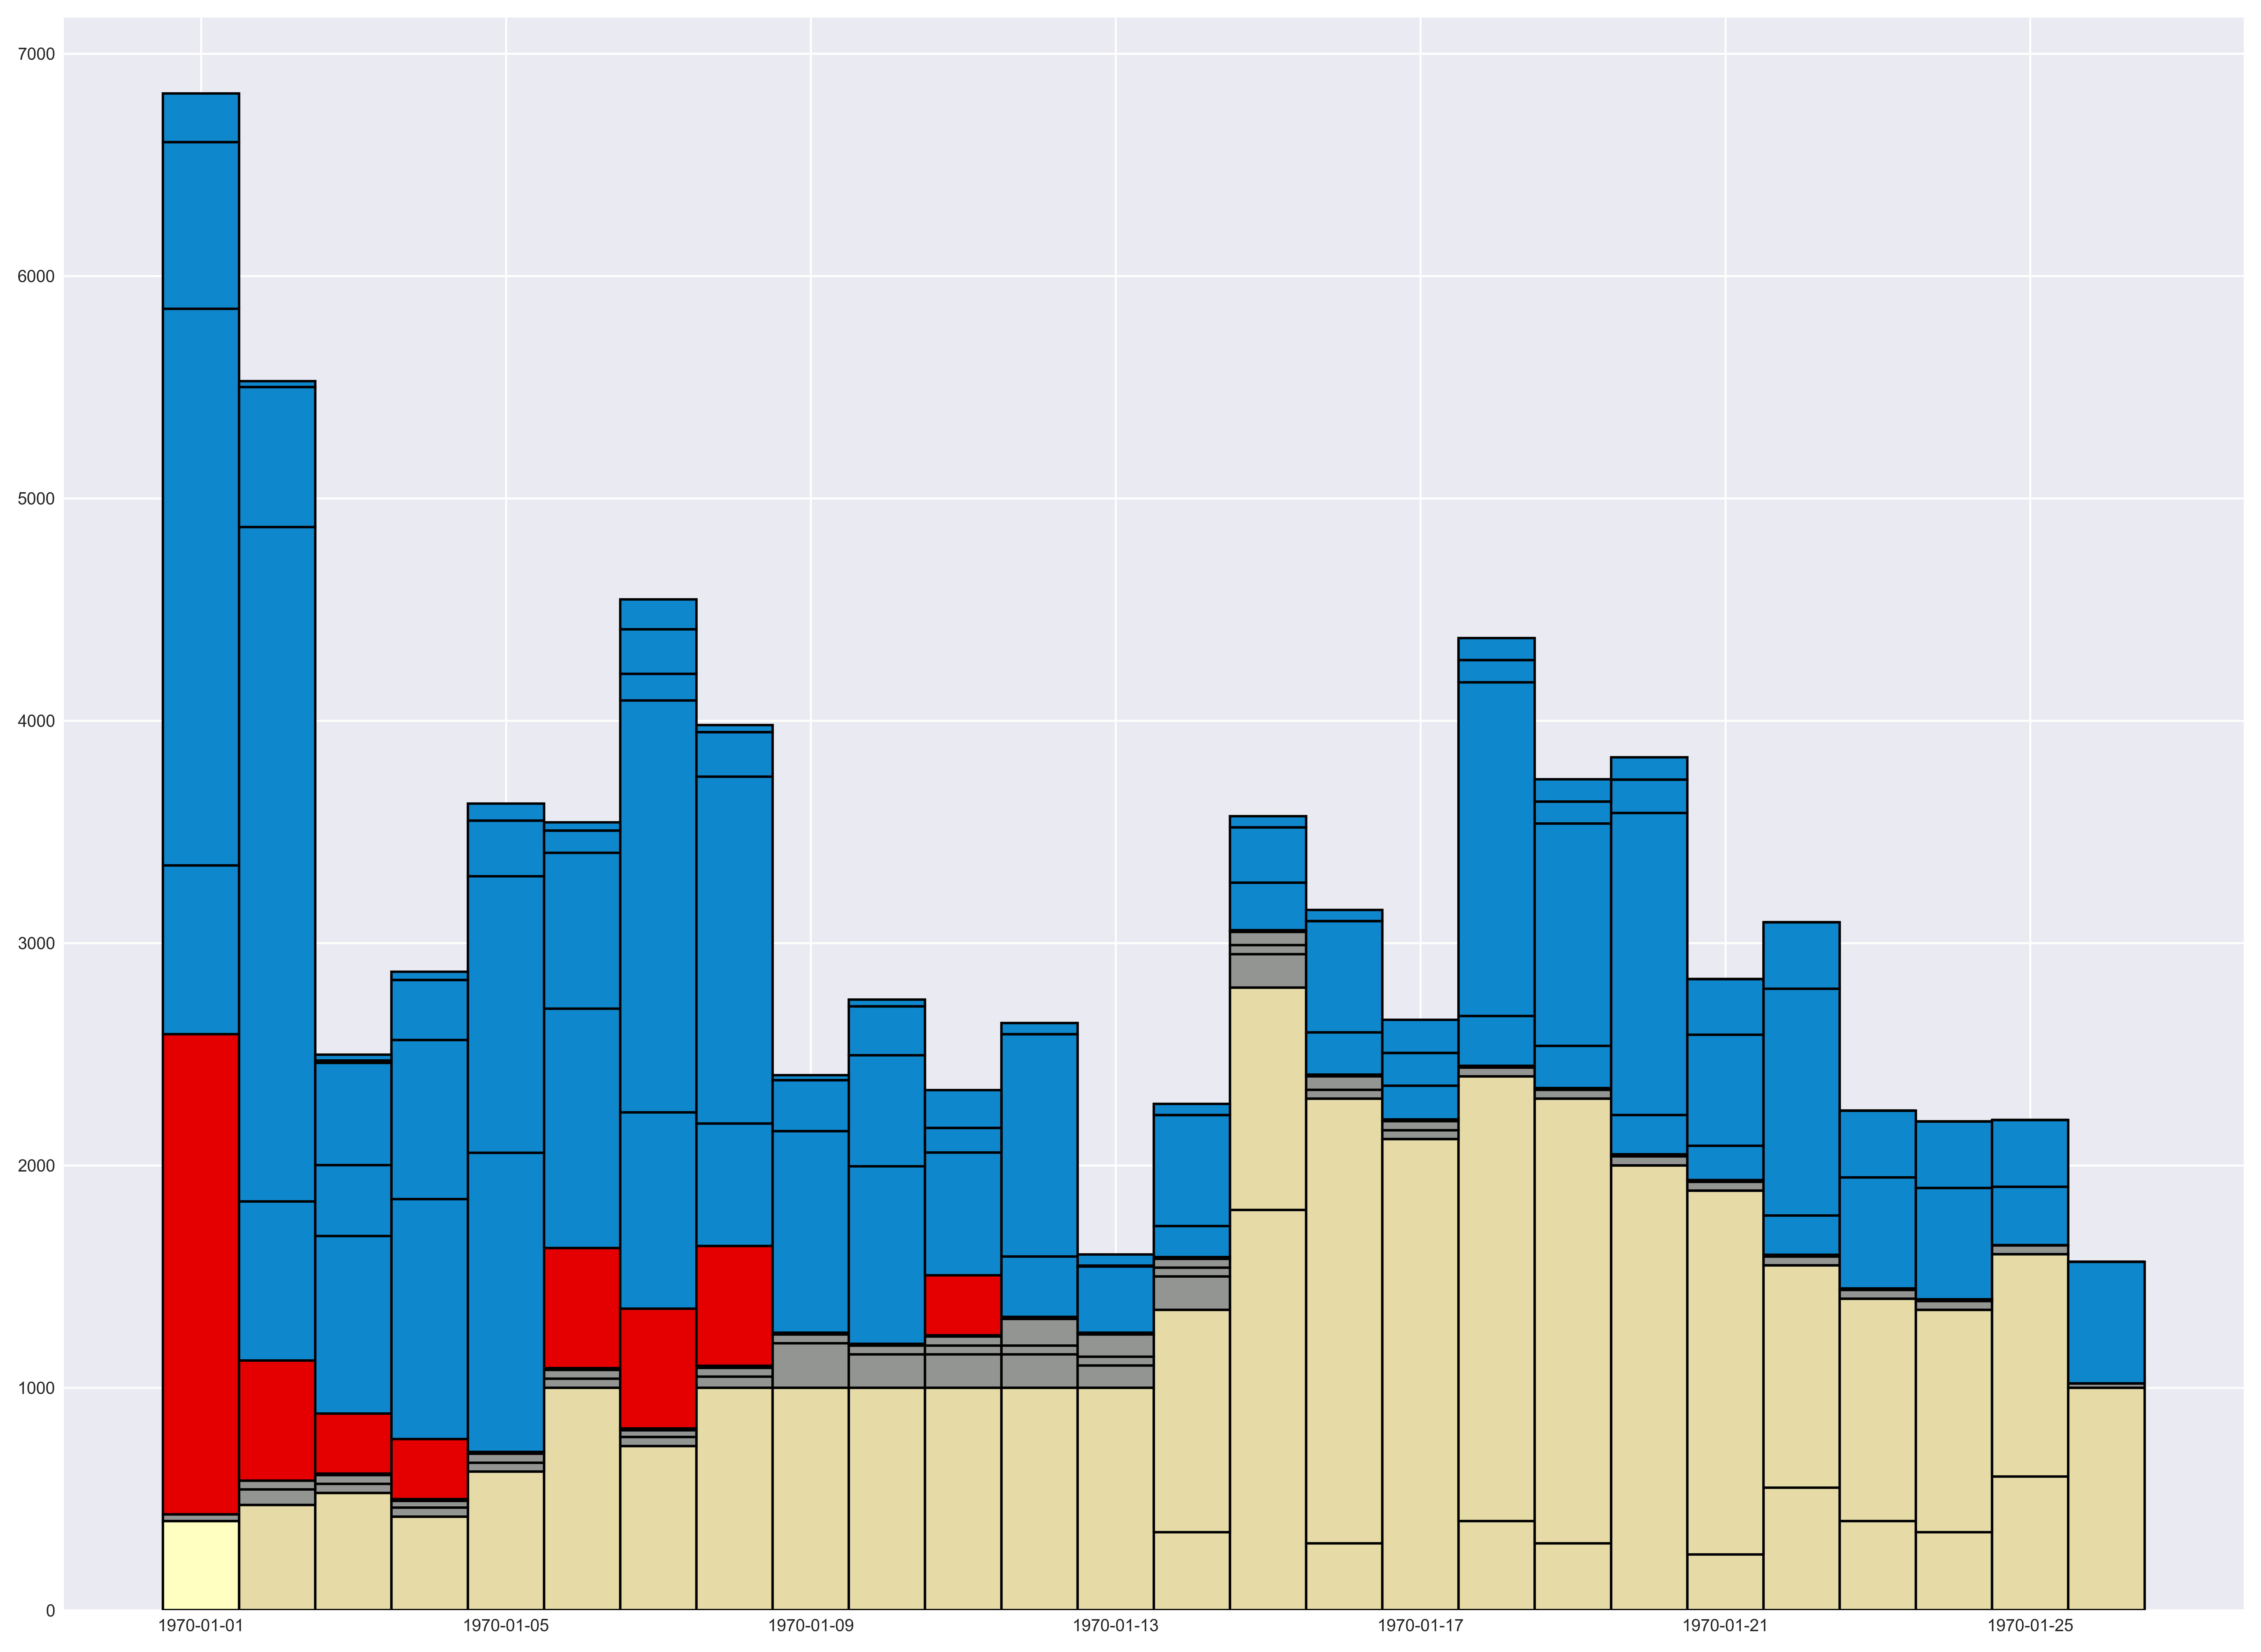

In [7]:
fluids_interval = timedelta(hours=24)

sql_fluids_in = """
SELECT 
    stop as time, --for simplicity assume everything has been infused at the stop time
    ordercategoryid,
    ordercategory,
    fluidin,
    CASE 
        WHEN ordercategoryid IN (
            61 --Infuus - Bloedproducten
        ) THEN 'xkcd:red'
        WHEN ordercategoryid IN (
            65, --2. Spuitpompen
            26, --Injecties Tractus Digestivus
            25, --Injecties Haematologisch
            24, --Injecties Circulatie/Diuretica
            15, --Injecties Antimicrobiele middelen
            23, --Injecties CZS/Sedatie/Analgetica
            55, --Infuus - Crystalloid
            27, --Injecties Overig
            67 --Injecties Hormonen/Vitaminen/Mineralen
        ) THEN 'xkcd:water blue'
        WHEN ordercategoryid IN (
            17 --Infuus - Colloid
        ) THEN 'xkcd:cream'
        WHEN ordercategoryid IN (
            114, --Voeding Enteraal
            63, --Voeding Enteraal oud
            39, --Voeding Parenteraal
            42 --Voeding Drinken
        ) THEN 'xkcd:beige'
        WHEN ordercategoryid IN (
            70, --Niet iv Tractus Respiratorius
            119, --Niet IV Groot Volume
            21, --Niet iv Antimicrobiele middelen
            71, --Niet iv Hormonen/Vitaminen/Mineralen
            32, --Niet iv Overig
            31, --Niet iv Tractus Digestivus
            29, --Niet iv CZS/Sedatie/Analgetica
            69 --Niet iv Zalven/Crèmes/Druppels
        ) THEN 'xkcd:grey'
    END AS colour
FROM drugitems
WHERE fluidin > 0 AND --in ml
    --admissionid = 0
    --admissionid = 5465
    admissionid = 3441
"""
fluids_in = pd.read_sql(sql_fluids_in,con)
fluids_in['time'] = pd.to_datetime(fluids_in['time'], unit='ms')
fluids_in_resampled = fluids_in.set_index(['time', 'ordercategory', 'ordercategoryid','colour']).groupby(['ordercategory', 'ordercategoryid','colour']).resample(fluids_interval, level=0).sum()

index_start = fluids_in_resampled.index.get_level_values('time').min()
index_end = fluids_in_resampled.index.get_level_values('time').max()
fluids_in_reindexed = fluids_in_resampled.reset_index().set_index('time').groupby(
    ['ordercategory', 'ordercategoryid','colour']).apply(
    reindex_by_date, index_start=index_start, index_end=index_end, interval=fluids_interval)[['fluidin']]
fluids_in_reindexed.index.set_names('time', level=3, inplace=True)

#plot by iteratively stacking fluid bars
fluids = fluids_in_reindexed.sort_index().groupby(['colour','ordercategory', 'ordercategoryid'])
ax3 = plt.subplot(111)
ax3.xaxis_date()

previous_data = None #store the previous data to determine where the plotting should start
                                            
for name, group in fluids:
    fluid = group.reset_index()
    time = fluid['time']
    data = fluid['fluidin']
    colour = fluid['colour']
    if not previous_data is None:
        ax3.bar(time, data, width=fluids_interval, bottom=previous_data, color=colour, edgecolor='black')
        previous_data = previous_data+data
    else:
        ax3.bar(time, data, width=fluids_interval, color=colour, edgecolor='black')
        previous_data = data
        
plt.show()

## Fluids: OUT

No handles with labels found to put in legend.


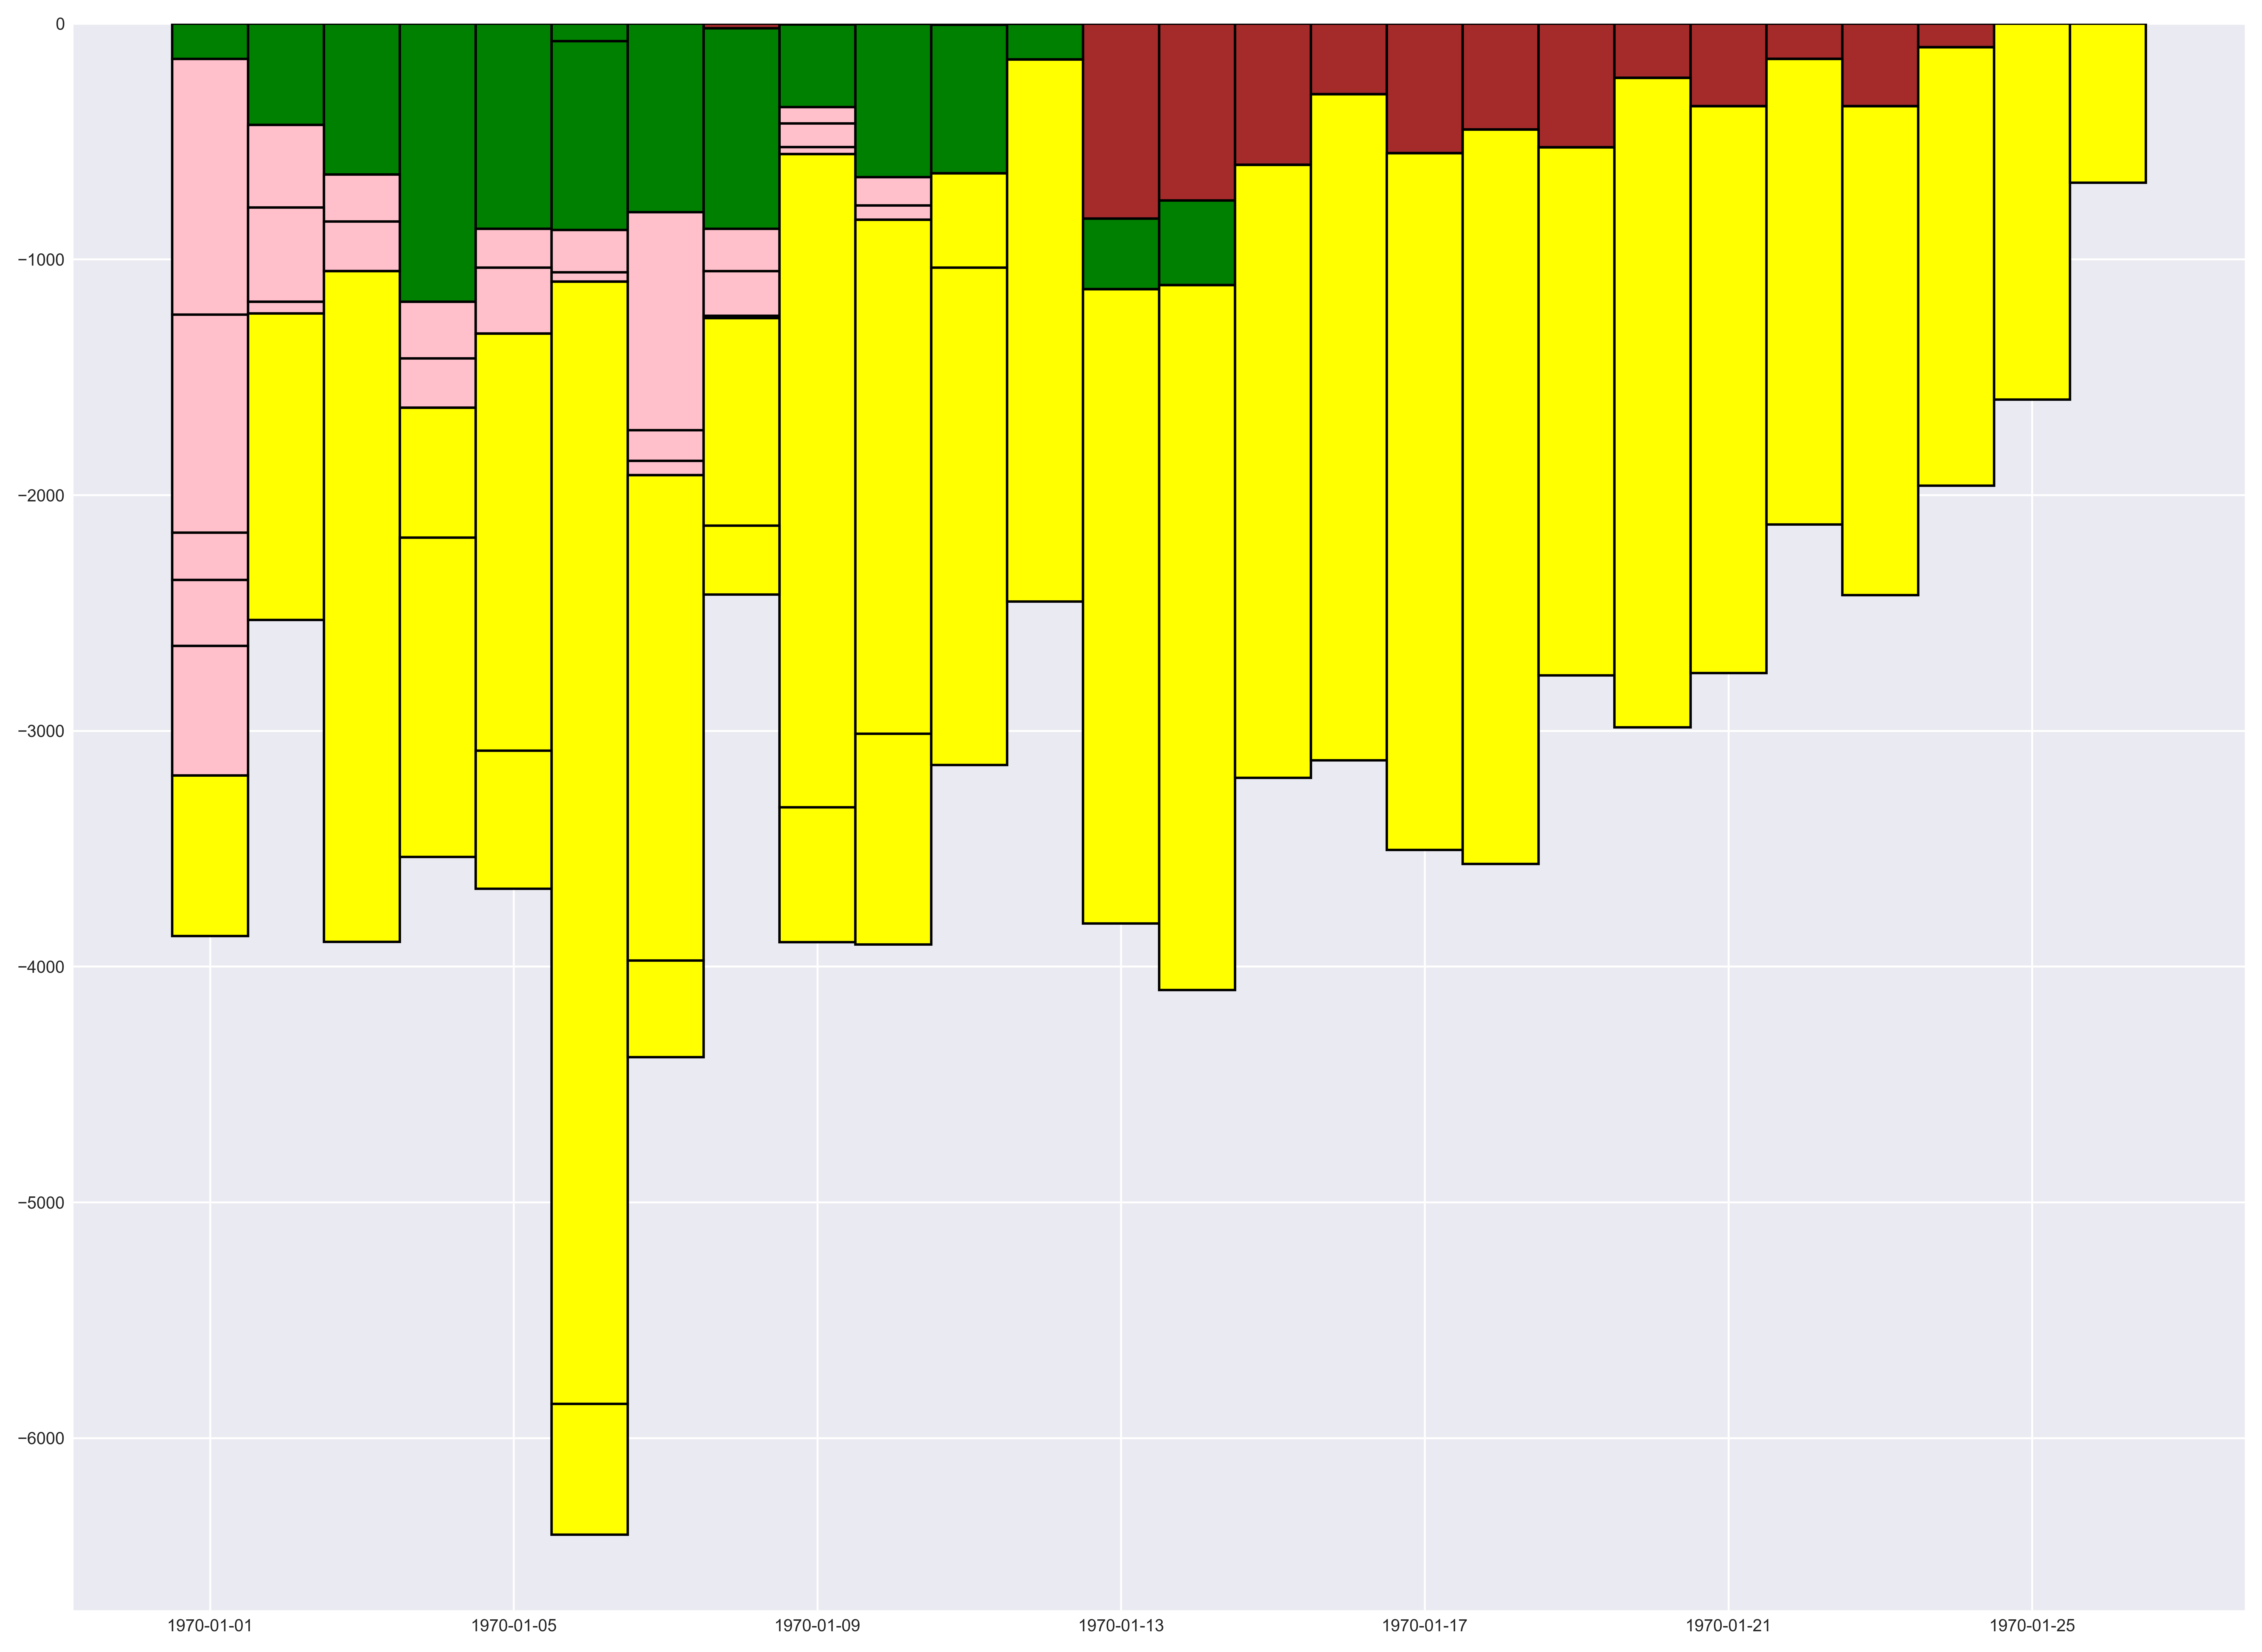

In [8]:
#get the fluids out
sql_fluids_out = """
SELECT
    measuredat as time,
    itemid,
    item,
    value,
    CASE 
        WHEN itemid IN (
            8699, --Thoraxdrain1 Productie
            8700, --Thoraxdrain2 Productie
            8701, --Thoraxdrain3 Productie
            8717, --Wonddrain1 Productie
            8719, --Wonddrain2 Productie
            8720, --Wonddrain3 Productie
            8721, --Wonddrain4 Productie
            8770, --Ventrikeldrain1 Uit
            8772, --Pericarddrain Uit
            12503, --Thoraxdrain4 Productie
            12504, --Thoraxdrain5 Productie
            12506, --Thoraxdrain6 Productie
            10592, --Ascitespunctie
            10595, --Pleurapunctie
            9626, --Wondlekkage
            14428, --Wonddrain5 Productie
            14429, --Wonddrain6 Productie
            12553 --Fistel
        ) THEN 'pink'
        WHEN itemid IN (
            8774, --Maaghevel
            8777, --MaagRetentieWeg
            8780, --Braken
            8782, --Sengtaken
            8925, --Maagzuig
            12580 --Galdrain Uit
        ) THEN 'green'
        WHEN itemid IN (
            8784, --Jejunostoma
            8786, --Ileostoma
            8788, --Colostoma
            8789 --Ontlasting
        ) THEN 'brown'
        WHEN itemid IN (
            8792 --Bloedverlies
        ) THEN 'red'
        WHEN itemid IN (
            8794, --UrineCAD
            8796, --UrineSupraPubis
            8798, --UrineSpontaan
            8800, --UrineIncontinentie
            8803, --UrineUP
            8805, --CVVH Onttrokken
            8806, --Hemodialyse onttrekken
            8808, --Peritoneaaldialyse
            10743, --Nefrodrain li Uit
            10745, --Nefrodrain re Uit
            19921, --UrineSplint Li
            19922 --UrineSplint Re
        ) THEN 'yellow'
        WHEN itemid IN (
            9564, --NDT-syst.
            9360, --Lumbaaldrain Uit
            15257, --Cisternale drain Uit
            13031, --Spinaaldrain Uit
            13495, --Ventrikeldrain2 Uit
            10597 --Liquorpunctie
        ) THEN 'transparant'
        WHEN itemid IN (
            12792 --Kolven
        ) THEN 'white'
    END AS colour
FROM numericitems
WHERE 
    fluidout > 0 AND
    --admissionid = 0
    admissionid = 3441
ORDER BY itemid
"""
fluids_out_items = pd.read_sql(sql_fluids_out,con)
fluids_out_items['time'] = pd.to_datetime(fluids_out_items['time'], unit='ms')

#resample to hourly
fluids_out_resampled = fluids_out_items.set_index(['time', 'item', 'itemid','colour']).groupby(['item','itemid','colour']).resample(fluids_interval, level=0).sum()

#reindex to hourly (add empty records for plotting)
index_start = fluids_out_resampled.index.get_level_values('time').min()
index_end = fluids_out_resampled.index.get_level_values('time').max()
fluids_out_items_reindexed = fluids_out_resampled.reset_index().set_index('time').groupby(
    ['item','itemid','colour']).apply(
    reindex_by_date, index_start=index_start, index_end=index_end, interval=fluids_interval)[['value']]
fluids_out_items_reindexed.index.set_names('time', level=3, inplace=True)

#plot by iteratively stacking fluid bars
drains = fluids_out_items_reindexed.sort_index().groupby(['colour','item','itemid'])
ax3 = plt.subplot(111)
ax3.xaxis_date()

previous_data = None #store the previous data to determine where the plotting should start
                                            
for name, group in drains:
    drain = group.reset_index()
    time = drain['time']
    data = -drain['value']
    colour = drain['colour']
    if not previous_data is None:
        ax3.bar(time, data, width=fluids_interval, bottom=previous_data, color=colour, edgecolor='black')
        previous_data = previous_data+data
    else:
        ax3.bar(time, data, width=fluids_interval, color=colour, edgecolor='black')
        previous_data = data
        
ax3.legend()
plt.show()

## Flowsheet style data
Both from numericitems as well as listitems

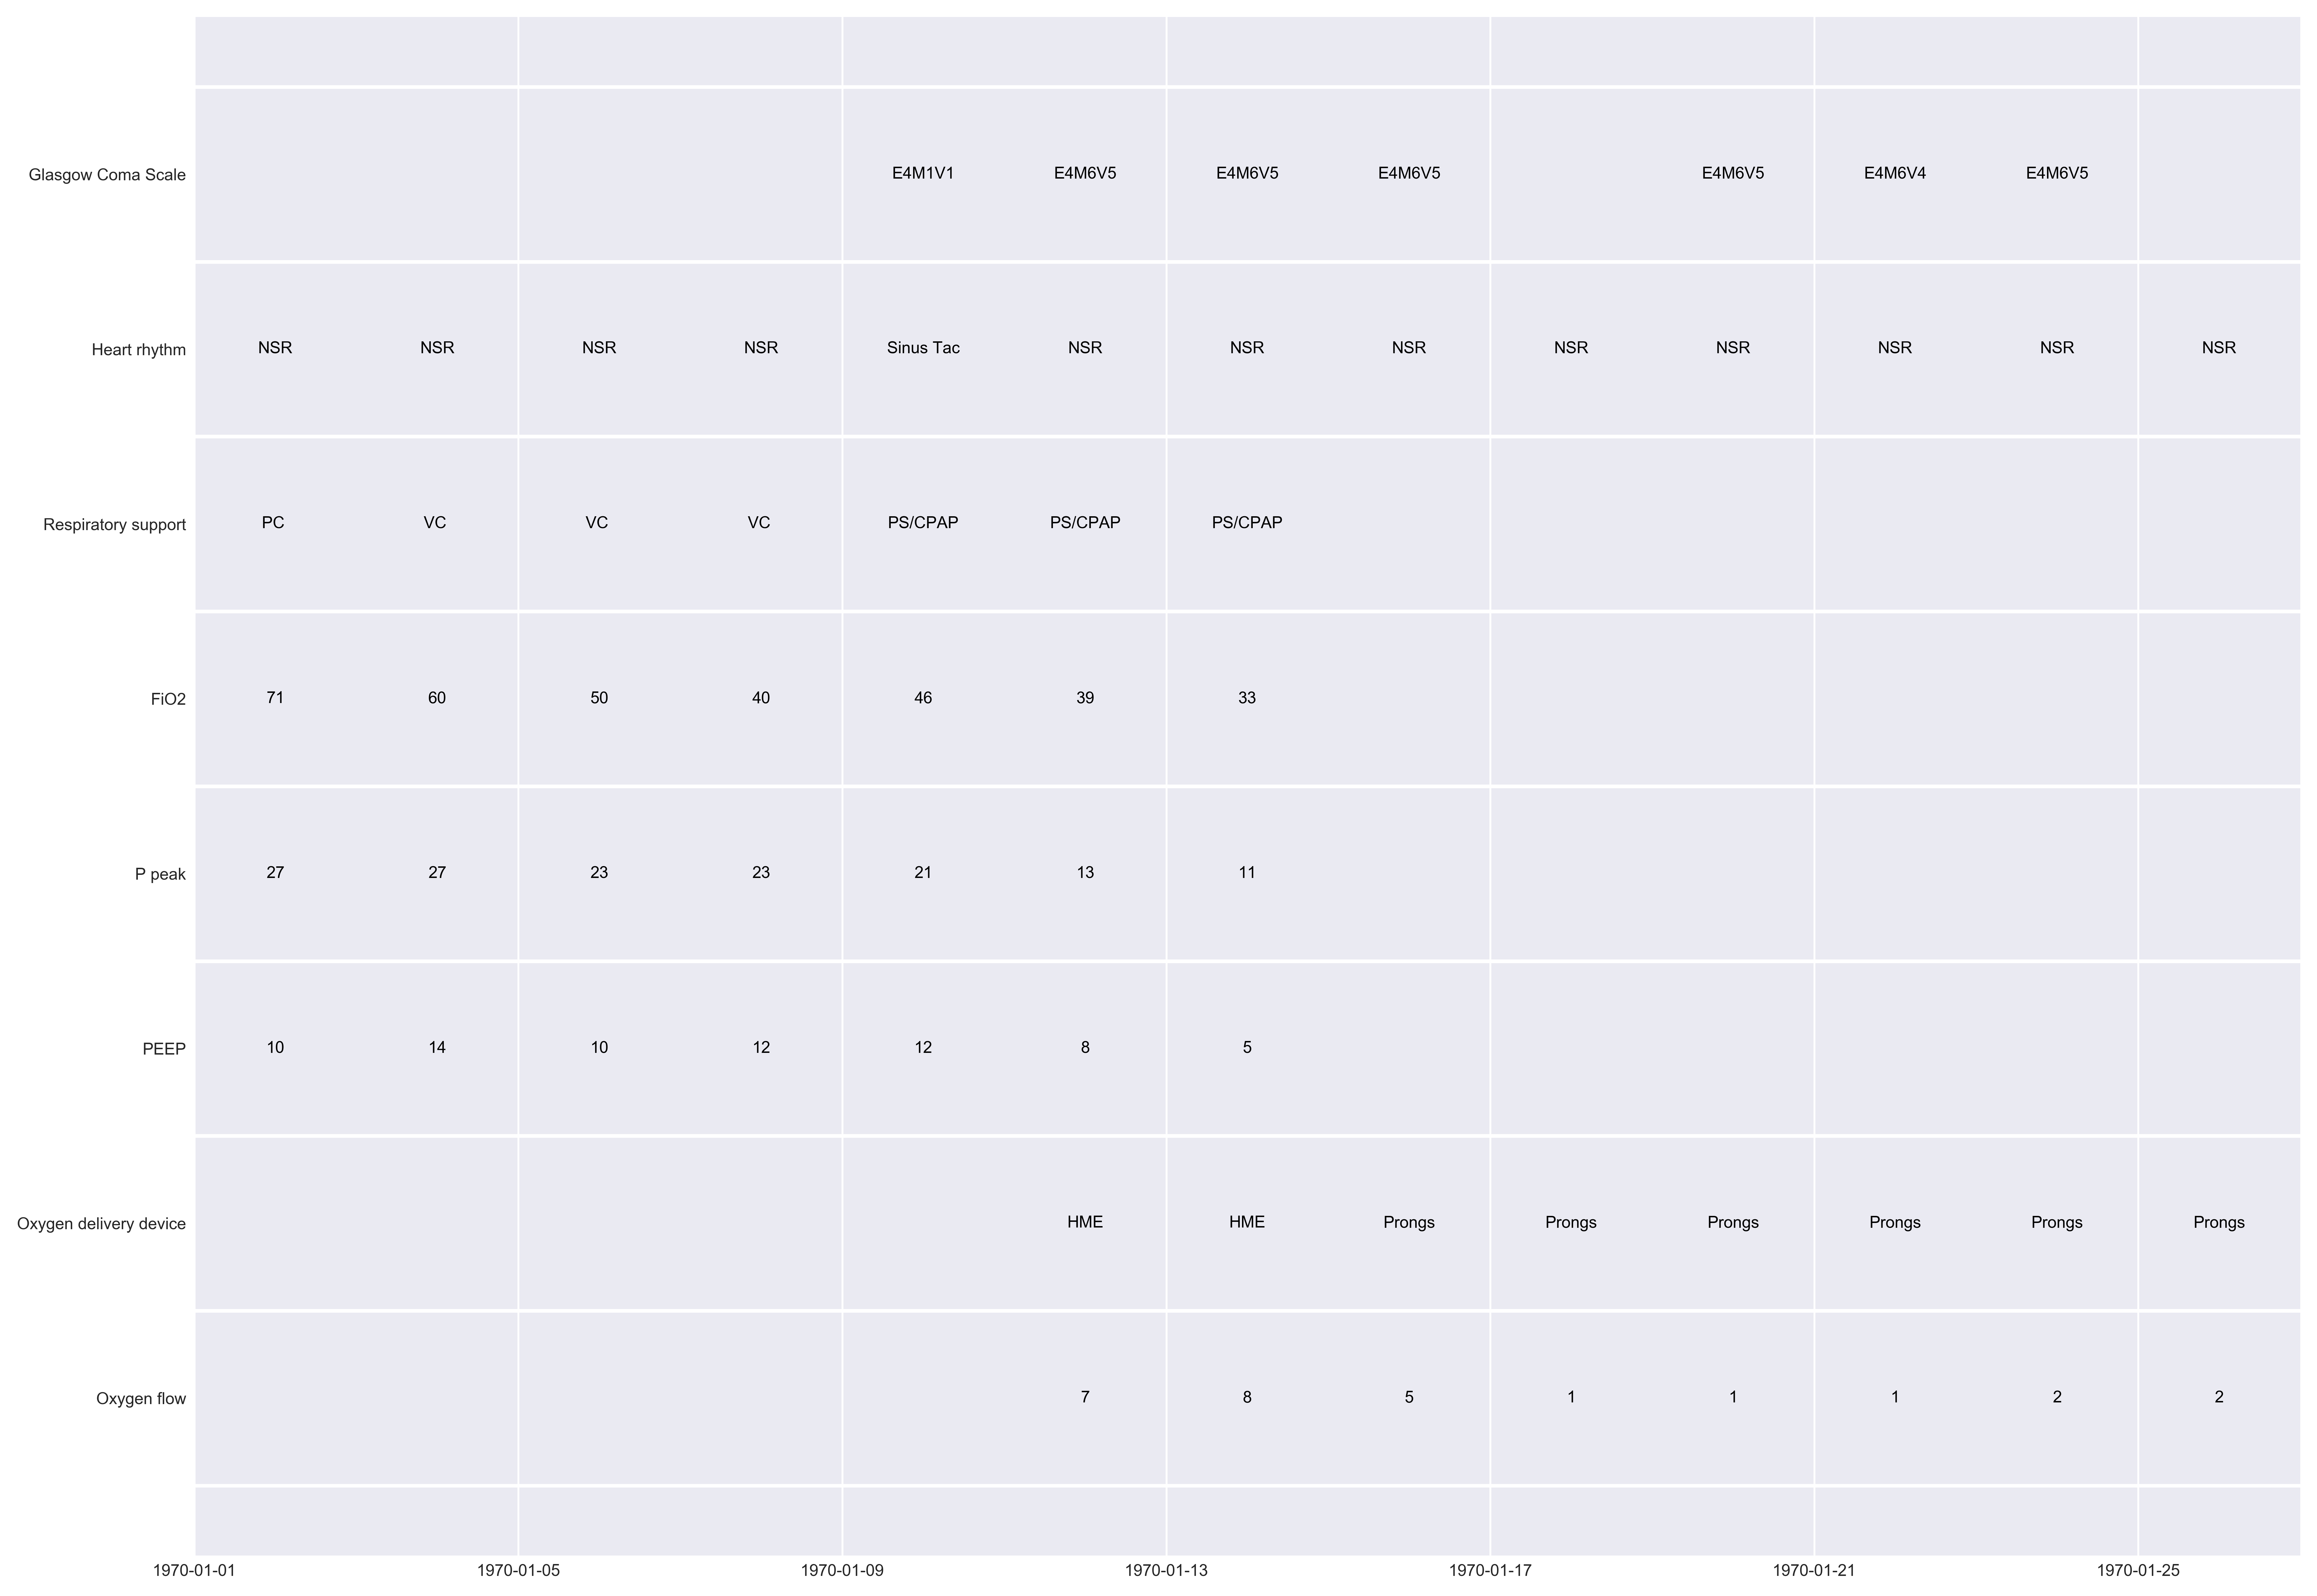

In [9]:
text_info_interval = timedelta(hours=96)

admissionid = 3441
sql_flowsheet = """
WITH gcs_components AS (
    SELECT 
        eyes.admissionid,
        CASE eyes.itemid
            WHEN 6732 THEN 5 - eyes.valueid     --Actief openen van de ogen
        END AS eyes_score,
        CASE motor.itemid
            WHEN 6734 THEN 7 - motor.valueid    --Beste motore reactie van de armen
        END AS motor_score,
        CASE verbal.itemid
            WHEN 6735 THEN 6 - verbal.valueid   --Beste verbale reactie
        END AS verbal_score,
        eyes.registeredby,
        eyes.measuredat AS time       
    FROM listitems eyes
    LEFT JOIN listitems motor ON
        eyes.admissionid = motor.admissionid AND
        eyes.measuredat = motor.measuredat AND
        motor.itemid IN (
            6734 --Beste motore reactie van de armen
        )
    LEFT JOIN listitems verbal ON
        eyes.admissionid = verbal.admissionid AND
        eyes.measuredat = verbal.measuredat AND
        verbal.itemid IN (
            6735 --Beste verbale reactie
        )
    WHERE 
        eyes.itemid IN (
            6732 --Actief openen van de ogen
        )
        AND eyes.registeredby IN (
            'ICV_IC-Verpleegkundig',
            'ICV_MC-Verpleegkundig'
        )
        AND eyes.admissionid = {admissionid}
)
SELECT 
    time,
    'GCS score' AS item,
    'E' || eyes_score || 'M' || motor_score || 'V' || (
        CASE 
            WHEN verbal_score < 1 THEN 1
            ELSE verbal_score 
        END)
        --|| '=' || (
        --    eyes_score + motor_score + (
        --    CASE 
        --        WHEN verbal_score < 1 THEN 1
        --        ELSE verbal_score 
        --    END
        --    )
        --) 
    AS value,
    eyes_score + motor_score + (
            CASE 
                WHEN verbal_score < 1 THEN 1
                ELSE verbal_score 
            END
            ) 
    AS valueid,
    '00. Glasgow Coma Scale' AS category
    FROM gcs_components

UNION

SELECT
    measuredat AS time,
    item,
    value,
    valueid,
    CASE
        WHEN itemid IN (
            9534, --Type beademing Evita 1
            6685, --Type Beademing Evita 4
            12290 --Ventilatie Mode (Set)
        ) THEN '02-1. Respiratory support'
        WHEN itemid IN (
            8189 --Toedieningsweg
        ) THEN '03-1. Oxygen delivery device'
        WHEN itemid IN (
            6671 --Hartritme
        ) THEN '01. Heart rhythm'
    END AS category
FROM listitems
WHERE 
    itemid IN (
        9534, --Type beademing Evita 1
        6685, --Type Beademing Evita 4
        12290, --Ventilatie Mode (Set)
        8189, --Toedieningsweg
        6671 --Hartritme 
    )
    AND admissionid = {admissionid}
    
UNION

SELECT
    measuredat AS time,
    item,
    CAST(value AS varchar),
    0 AS valueid, --to allow UNION both tables
    CASE
        WHEN itemid IN (
            6699, --FiO2 %: setting on Evita ventilator
            12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
            12369 --SET %O2: used with BiPap Vision ventilator
        ) THEN '02-2. FiO2'
        WHEN itemid IN (
            -- Peak pressures on ventilator
            8852, --P max
            8877, --Peak druk -- Evita
            12281, --Piek druk --Servo-i
            16239 --Zephyros Ppeak
        ) THEN '02-3. P peak'
        WHEN itemid IN (
            --PEEP settings on respiratory support
            12284, --PEEP (Set): setting on Servo-i ventilator
            8862, --PEEP/CPAP: setting on Evita ventilator
            --8879, --PEEP (gemeten): measured by Evita ventilator
            16250 --Zephyros PEEP
        ) THEN '02-4. PEEP'
        WHEN itemid IN (
            --Oxygen flow
            8845, -- O2 l/min
            10387, --Zuurstof toediening (bloed)
            18587 --Zuurstof toediening
        ) THEN '03-2. Oxygen flow'
    END AS category
FROM numericitems
WHERE 
    itemid IN (
        -- FiO2
        6699, --FiO2 %: setting on Evita ventilator
        12279, --O2 concentratie --measurement by Servo-i/Servo-U ventilator
        12369, --SET %O2: used with BiPap Vision ventilator
        
        -- Peak pressures on ventilator
        8852, --P max
        8877, --Peak druk -- Evita
        12281, --Piek druk --Servo-i
        16239, --Zephyros Ppeak

        --PEEP settings on respiratory support
        12284, --PEEP (Set): setting on Servo-i ventilator
        8862, --PEEP/CPAP: setting on Evita ventilator
        --8879, --PEEP (gemeten): measured by Evita ventilator
        16250, --Zephyros PEEP
        
        --Oxygen flow
        8845, -- O2 l/min
        10387, --Zuurstof toediening (bloed)
        18587 --Zuurstof toediening
    ) 
    AND admissionid = {admissionid}
""".format(admissionid=admissionid)

flowsheet = pd.read_sql(sql_flowsheet,con)
flowsheet['time'] = pd.to_datetime(flowsheet['time'], unit='ms')

#downsample to hourly, re-index to create same numer of rows per category and the downsample to requested interval
flowsheet_resampled_hourly = flowsheet.set_index(['time','category']).sort_values(['valueid'],ascending=False).groupby(
    ['category']).resample(timedelta(hours=1), level=0).first()

index_start = flowsheet_resampled_hourly.index.get_level_values('time').min()
index_end = flowsheet_resampled_hourly.index.get_level_values('time').max()
flowsheet_reindexed_hourly = flowsheet_resampled_hourly.reset_index().set_index('time').groupby(
    ['category']).apply(
    reindex_by_date, index_start=index_start, index_end=index_end, interval=timedelta(hours=1), 
    method=None, fill_value=np.NaN)[['value', 'valueid']]
flowsheet_reindexed_hourly.index.set_names('time', level=1, inplace=True)

flowsheet_resampled = flowsheet_reindexed_hourly.sort_values(['valueid'],ascending=False).groupby(
    ['category']).resample(flowsheet_interval, level=1).first()


#translate some values:
flowsheet_resampled.loc[flowsheet_resampled['value'] == 'Kunstneus', 'value'] = 'HME'
flowsheet_resampled.loc[flowsheet_resampled['value'] == 'O2-bril', 'value'] = 'Prongs'

labels = []
ticks = []
pos = 0

fig, ax = plt.subplots()
ax.xaxis_date()

#display flowsheet
flowsheet_groups = flowsheet_resampled.fillna('').reset_index().groupby(['category'])
for name, group in flowsheet_groups:
    label = re.sub(r'[0-9\-].+\.\s', '', name)
    labels.append(label) #saves the label for ticks
    ticks.append(pos) ##saves the position for ticks
    for index, row in group.iterrows():
        ax.barh(pos, flowsheet_interval, left=row['time'], height=4, facecolor='white', alpha=0.0,
                edgecolor='white', linewidth=1)
        ax.annotate(row['value'], xy=(row['time']+flowsheet_interval/2, pos), fontsize='x-small',
                     color='black', horizontalalignment='center', verticalalignment='center')
        ax.axhline(y=pos+2, ls='-', color='white') #horizontal gridline
    pos = pos - 4

ax.axhline(y=pos+2, ls='-', color='white')
    
#shows the labels and a flowsheet grid
ax.set_yticks(ticks)
ax.set_yticklabels(labels)
ax.grid(False, which='major', axis='y')
plt.show()

## Drugs: continuous infusions

In [10]:
drugs_info_interval = timedelta(hours=24)

admissionid = 3441
sql_drugitems_continous = """
SELECT
    ordercategoryid,
    ordercategory,
    itemid,
    item,
    CASE 
        WHEN rate >= 0 THEN rate
        ELSE dose
    END AS rate,
    start AS time,
    stop - start AS duration,
    action
FROM drugitems
WHERE 
    iscontinuous = B'1'
    AND NOT itemid IN (
7257, --Glucose 5 %
7291, --NaCl 0,45%/Glucose 2,5%
7293, --NaCl 0,9 %
7316, --Ri-Lac (Ringers lactaat)
8937, --Drukzak
8939, --Medicijnlijn medicatie
12610, --Nutrison Sterilized water
16904 --Drukzak IABP
    )
    AND admissionid = {}
ORDER BY itemid, start
""".format(admissionid)

drugitems_continous = pd.read_sql(sql_drugitems_continous,con)
drugitems_continous['time'] = pd.to_datetime(drugitems_continous['time'], unit='ms')
drugitems_continous['duration'] = pd.to_timedelta(drugitems_continous['duration'], unit='ms')

#resample for displaying annotations (rates)
drugitems_continous_resampled = drugitems_continous.set_index(['time','ordercategory','item','itemid']).groupby(
    ['ordercategory','item','itemid']).resample(fluids_interval, level=0).max().reset_index()

drugitems_continous_groups = drugitems_continous.groupby(['ordercategory','item','itemid'])
drugitems_continous_groups_for_annotation = drugitems_continous_resampled.groupby(['ordercategory','item','itemid'])
labels = []
ticks = []
pos = 0

fig, ax = plt.subplots()
ax.xaxis_date()

#display continuous infusions
last_rate = 0
last_annotation_time = 0
for name, group in drugitems_continous_groups:
    label = name[1]
    labels.append(label) #saves the label for ticks
    ticks.append(pos) ##saves the position for ticks
    for index, row in group.iterrows():
        ax.barh(pos, row['duration'], left=row['time'], height=10, facecolor='xkcd:slate blue',
                edgecolor='black', linewidth=0)
        
        if (last_annotation_time == 0) or (row['time'] - last_annotation_time >= drugs_info_interval): #only display data when interval has passed
            ax.annotate("{:.1f}".format(row['rate']), xy=(row['time'], pos + 5), xytext=(0,0), textcoords='offset points',
                        fontsize=10, color='black', horizontalalignment='left', verticalalignment='bottom')
        
            if row['rate'] > last_rate:
                #up arrow
                ax.plot(row['time'], pos, 's', markeredgecolor='black', markerfacecolor='white', markersize=22, markeredgewidth=1)
                ax.plot(row['time'], pos, 'r^', markersize=10, markeredgewidth=1)
                

            if row['rate'] < last_rate:
                #down arrow
                ax.plot(row['time'], pos, 's', markeredgecolor='black', markerfacecolor='white', markersize=22, markeredgewidth=1)
                ax.plot(row['time'], pos, 'gv', markersize=10, markeredgewidth=1)
                
            
            last_annotation_time = row['time']
            last_rate = row['rate']
    
    pos = pos - 15
    last_rate = 0
    last_annotation_time = 0
    
ax.set_yticks(ticks)
ax.set_yticklabels(labels)
plt.show()

## Processes
Continous interventions, life support, lines, drains, airways

### Processes: displayed 'as is'

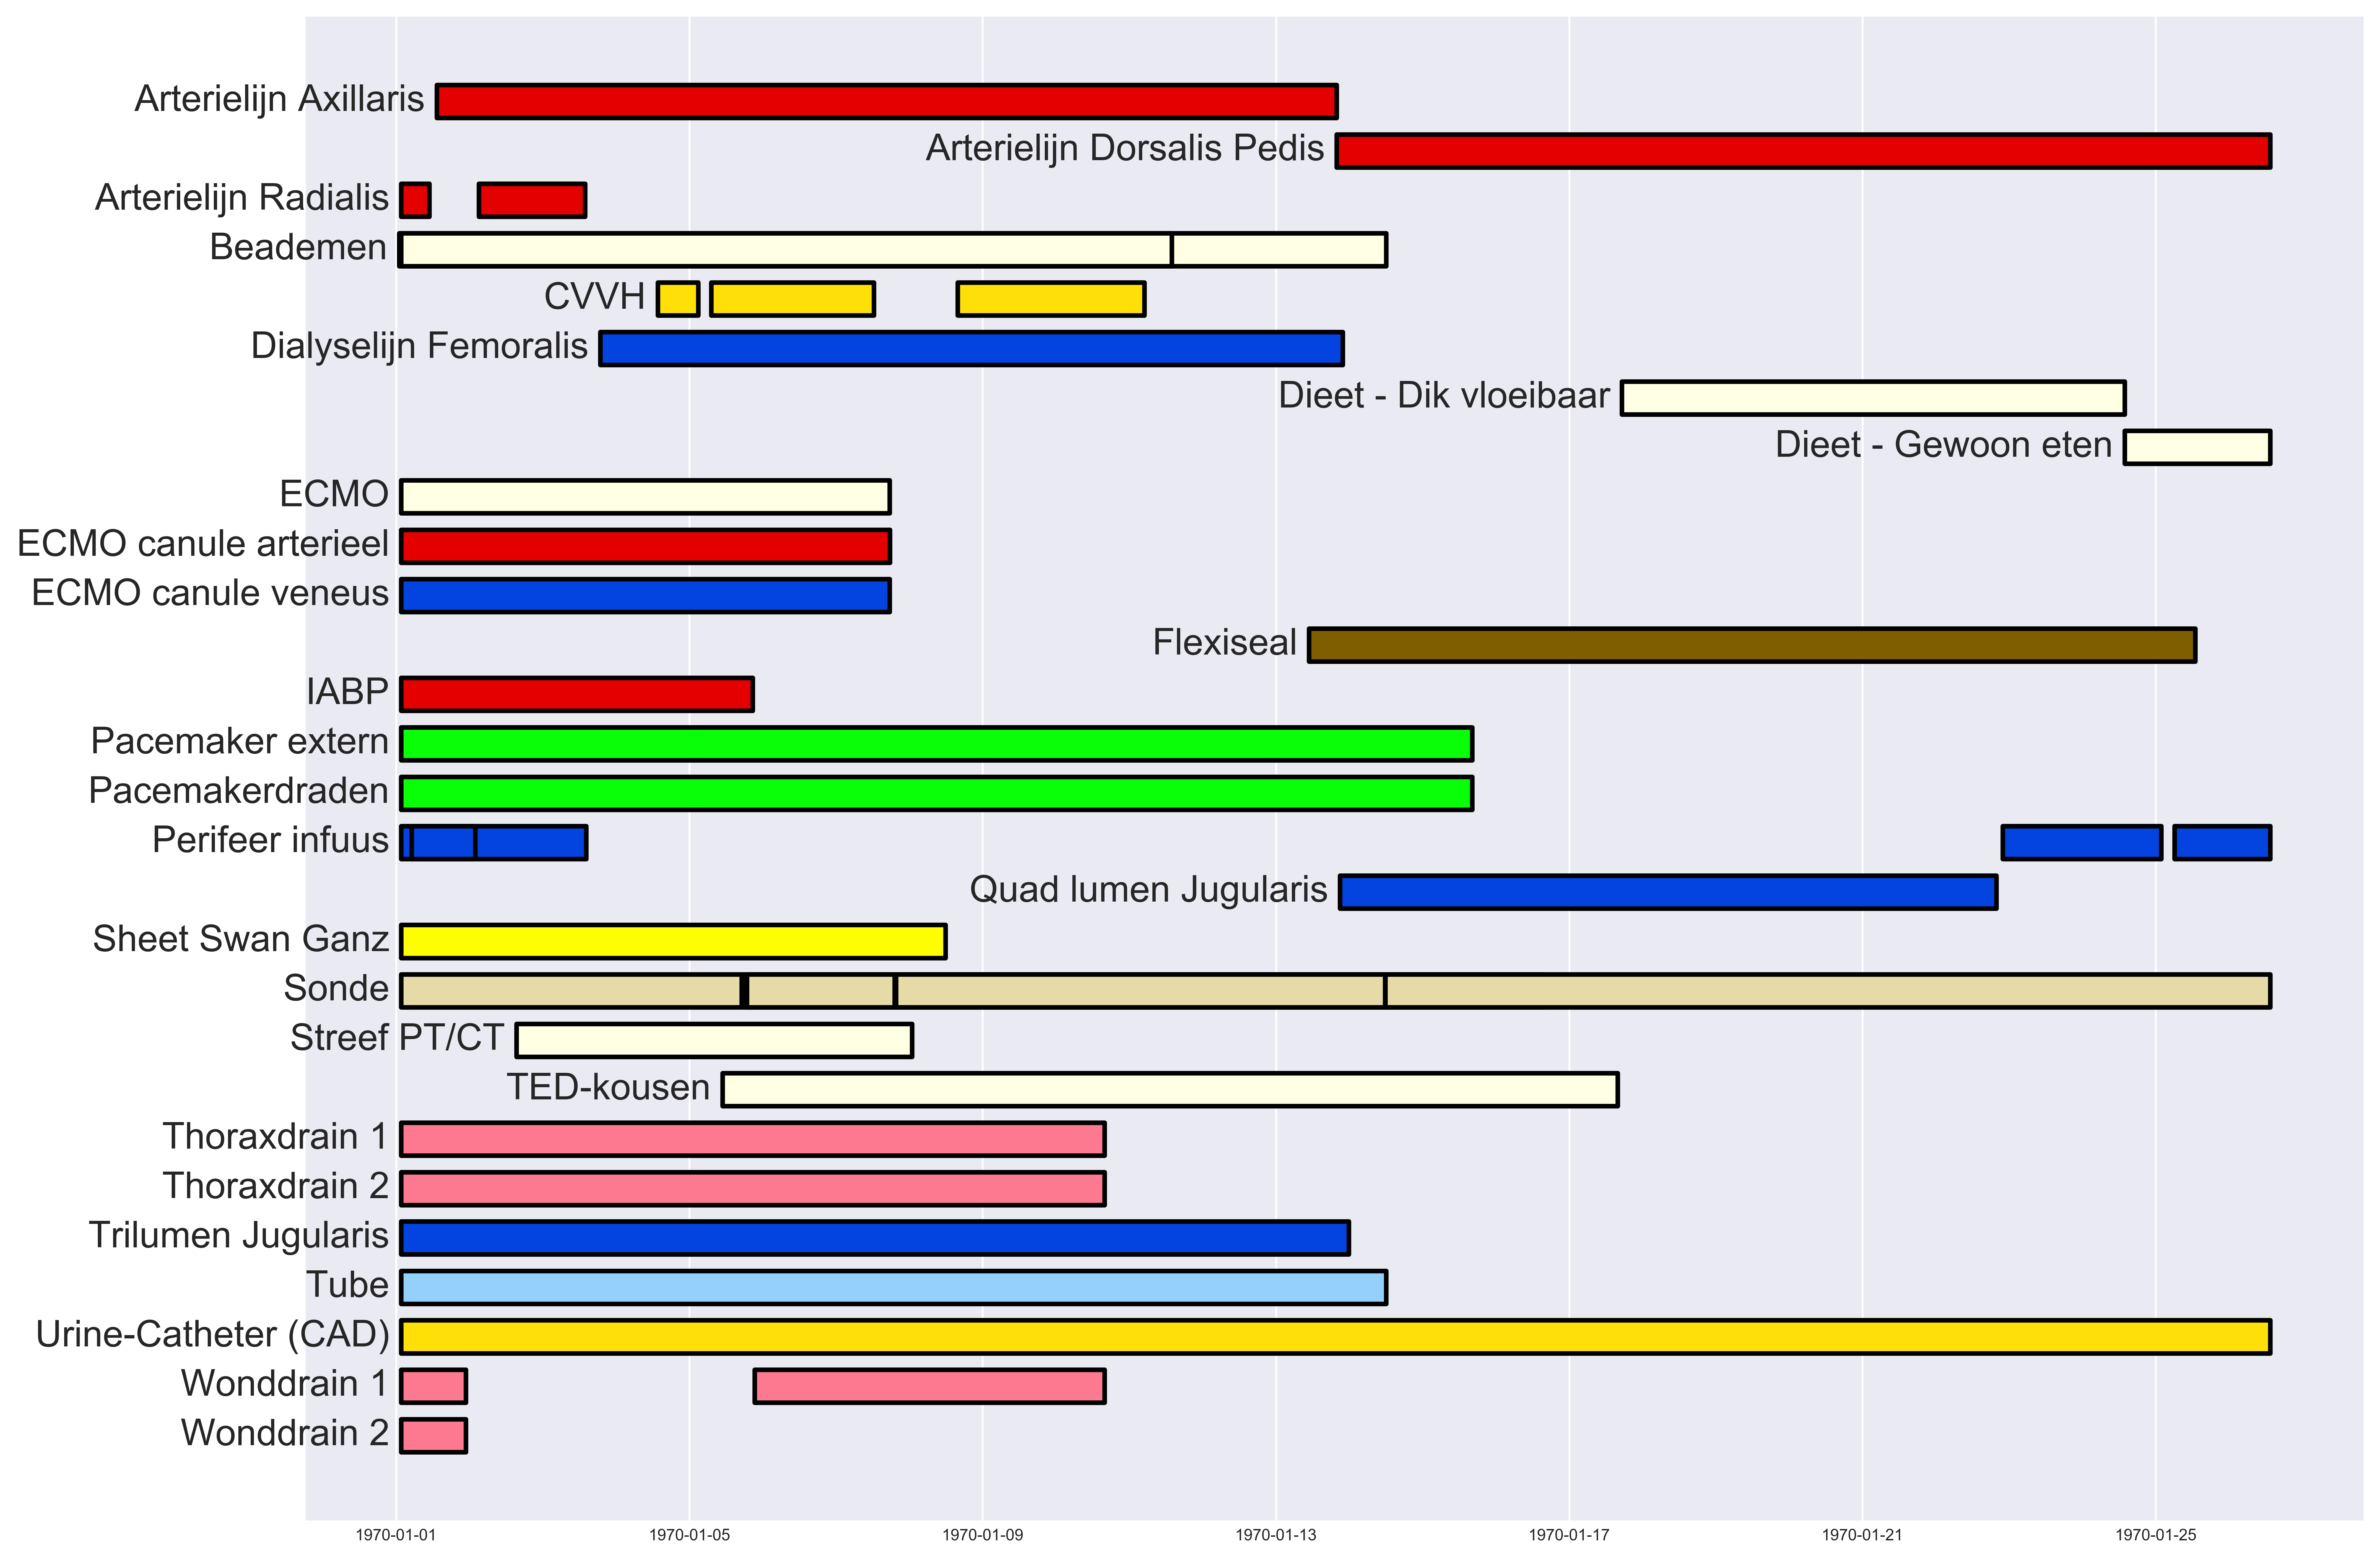

In [11]:
sql_process = """
SELECT 
    start AS time,
    stop - start AS duration,
    itemid,
    item,
    CASE
        WHEN itemid IN (
            9159, --Arterielijn Radialis
            9160, --Arterielijn Femoralis
            9164, --IABP femoralis
            10430, --IABP
            21091, --ECMO canule arterieel
            21056, --PiCCO arterielijn brachialis (22 cm)
            21057, --PiCCO arterielijn femoralis (20 cm)
            21093, --Bypass canule (art femoralis)
            9186, --Arterielijn Brachialis
            10619, --Arterielijn Ulnaris
            10620, --Arterielijn Dorsalis Pedis
            12539, --Arteriële sheet
            13099 --Arterielijn Axillaris
        ) THEN 'xkcd:red'
        WHEN itemid IN (
            9422, --Perifeer infuus
            9161, --Dialyselijn Femoralis
            9162, --Dialyselijn Jugularis
            9163, --Dialyselijn Subclavia
            9165, --Trilumen Femoralis
            9166, --Trilumen Jugularis
            9167, --Trilumen Subclavia
            9168, --Quad lumen Femoralis
            9169, --Quad lumen Subclavia
            9170, --Quad lumen Jugularis
            9185, --Sideport
            21187, --Enkel-Lumen Perifeer centrale catheter (PICC)
            21188, --Duo-Lumen Perifeer centrale catheter (PICC)
            21092, --ECMO canule veneus
            9594, --Enkel lumen Femoralis
            9595, --Enkel lumen Jugularis
            9596, --Enkel lumen Subclavia
            12399, --Duo lumen Femoralis
            12400, --Duo lumen Jugularis
            12401, --Duo lumen Subclavia
            12540, --Veneuze sheet
            13421, --Trauma catheter Femoralis
            13422, --Trauma catheter Jugularis
            13423 --Trauma catheter Subclavia
        ) THEN 'xkcd:blue'
        WHEN itemid IN (
            9614, --Sheet Swan Ganz
            9173, --Swan Ganz Femoralis
            9174, --Swan Ganz Jugularis
            9175 --Swan Ganz Subclavia
        ) THEN 'xkcd:bright yellow'
        WHEN itemid IN (
            12634, --Tube
            12635, --Tracheostoma
            18955 --Nasaal airway
        ) THEN 'xkcd:light blue'
        WHEN itemid IN (
            12465, --CVVH
            16363, --Hemodialyse
            9411, --Suprapubis catheter
            9412, --Urostoma            
            9415, --Urine-Catheter (CAD)
            13445, --Blaasspoelcatheter
            18718, --Plasmaferese
            18736 --Shunt
        ) THEN 'xkcd:dandelion'
        WHEN itemid IN (
            13005, --Rectum Canule
            15603, --Flexiseal
            15787, --Dubbelloops Stoma
            15793, --Faeces collector
            10730, --Jejuno-stoma
            10731, --Colo-stoma
            10732 --Ileo-stoma
        ) THEN 'xkcd:poop'
        WHEN itemid IN (
            9399, --Wonddrain 1
            9400, --Wonddrain 2
            9401, --Wonddrain 3
            9402, --Wonddrain 4
            9406, --Spoeldrain 1
            12427, --Spoeldrain 2
            9403, --Thoraxdrain 1
            9404, --Thoraxdrain 2
            9405, --Thoraxdrain 3
            12583, --Thoraxdrain 4
            12584, --Thoraxdrain 5
            12585 --Thoraxdrain 6
        ) THEN 'xkcd:carnation'
        WHEN itemid IN (
            10761, --Sengstaken
            9417 --Sonde
        ) THEN 'xkcd:beige'
        WHEN itemid IN (
            9541, --Pacemakerdraden
            9187, --Pacemaker extern
            18737 --Pacedraden via Swan Ganz
        ) THEN 'xkcd:fluorescent green'
        WHEN itemid IN (
            9574, --Maagzuig-drainage
            12579 --Galdrain
        ) THEN 'xkcd:bile'
        WHEN itemid IN (
            9180, --Epiduraal catheter
            9181, --Caminodrain
            9182, --Cisternale drain
            9184, --Lumbaaldrain
            9407,--Ventrikeldrain
            13009, --Parenchymdrain
            13035 --Spinaaldrain
        ) THEN 'xkcd:very light pink'
        WHEN itemid IN (
            7926, --Mobiliseren
            7927, --Buikligging
            9171, --Xx-Niet meer gebruiken Tracheostoma (Portex) (= Proces Tracheostoma)
            9176, --Xx-Niet meer gebruiken Miditracheotomie(= Proces Tracheostoma)
            9177, --Xx-Niet meer gebruiken Tracheostoma (Shiley)(= Proces Tracheostoma)
            9188, --X-Proces Lijnen/Catheter/Drain
            9323, --Wisselligging geven
            9325, --Weanen
            9327, --Streefwaarden drukken
            9328, --Beademen
            9348, --Niet meer gebruiken Plaats Tube
            9349, --Niet meer gebruiken Diepte Tube
            9350, --Niet meer gebruiken Maat Tube
            9373, --Niets per os
            9374, --Nuchter houden
            9379, --X-Proces Circulatie
            9380, --X-Proces Gastro-Intestinaal
            9381, --X-Proces Houding & Beweging
            9382, --X-Proces Huid
            9383, --X-Proces Infectie
            9384, --X-Proces Neurologisch
            9385, --X-Proces Overig
            9386, --X-Proces Psycho-sociaal
            9387, --X-Proces Respiratie
            9388, --X-Proces Urologisch
            9410, --Koelen patiënt (Actief)
            9414, --Roteren bed
            9419, --Xx-Niet meer gebruiken Maag-hevel
            9426, --ADL-zelfst.heid aanleren
            9430, --Anti-trendelenburg
            9431, --Arm in draagband
            9436, --CPP streefwaarden
            9437, --ICP- acceptatiewaarden
            9441, --Draaien als boomstam
            9448, --Kunstneuzen
            9453, --Trendelenburg
            9454, --Hoofdsteun max. 30 graden
            9455, --Benen niet belasten
            9456, --Niet balloneren
            9457, --Niet uitzuigen
            9477, --Opwarmen (Actief inwendig)
            9478, --Streef Ramsay
            9481, --Tractie
            9482, --Halfzittende houding toepassen
            9485, --Dieet
            9492, --Contactisolatie 1
            9493, --Intrinsic PEEP en Airtrap bepalen
            9494, --MRSA verpleging
            9495, --Strikte isolatie 1
            9499, --Koelen patiënt (Passief)
            9513, --Beademingsslangen niet ontkoppelen
            9514, --Niet nasaal uitzuigen
            9518, --Ondersteunen bij hoesten
            9519, --Ophoesten stimuleren
            9520, --Opwarmen (Actief uitwendig)
            9521, --Opwarmen (Passief uitwendig)
            9523, --Hechtingen
            9524, --Plat liggend verplegen
            9527, --Stabiele zijligging toepassen
            9531, --Vocht beperking
            9537, --Xx-Niet meer gebruiken (Duodenumsonde=Proces Sonde)
            9538, --Xx-Niet meer gebruiken PEG-sonde(=Proces Sonde)
            9544, --NDT-systeem
            9575, --Toegestaan orale vochttoediening
            9601, --Drukverband
            9613, --Hotline gebruiken
            9625, --PCA-pomp
            9671, --CPAP
            10428, --Xx-Niet meer gebruiken(Microsonde=Proces Sonde)
            10612, --Advies Houding&Beweging
            10618, --Xx-Niet meer gebruikenTracheostoma (Bivona)(= Proces Tracheostoma)
            10727, --Xx-Niet meer gebruiken!(Jejunumsonde= Proces Sonde)
            10740, --Beademen non-invasief
            12139, --Neo-pneumocatheter (Vietnam-drain)
            12632, --Zuigsysteem
            12936, --Streef PT/CT

            13173, --Fixatie (fixeren)
            13483, --PAC-PiCCO monitoring
            13806, --Fixatuur externe bovenbeen links
            13807, --Fixatuur externe bovenbeen rechts
            13808, --Fixatuur externe onderbeen links
            13809, --Fixatuur externe onderbeen rechts
            13810, --Fixatuur externe bekken
            13811, --Fixatuur externe hoofd/hals (Halo-frame)
            14759, --Angioseal
            14834, --Hypothermie koelfase
            14953, --Hypothermie onderhoud- & opwarmfase
            15143, --X-Proces Voeding
            15144, --Dieet - 40cc/uur
            15145, --Dieet - Streng vloeibaar
            15146, --Dieet - Dik vloeibaar
            15147, --Dieet - Gemalen eten
            15148, --Dieet - Gewoon eten
            15170, --Contactisolatie 2
            15171, --Aërogene isolatie 1
            15717, --PCIA
            15718, --PCEA
            15738, --Spreekklep
            15867, --TED-kousen
            15868, --Druppelisolatie
            15869, --Druppel/Contactisolatie
            15870, --Beschermende isolatie
            16352, --Peritoneaal catheter
            16354, --Neustampon (bellocq en/of vaseline gaas)
            16358, --Botnaald
            16362, --24 uurs urine sparen
            16910, --ICD
            18740, --Botlap verwijderd
            18741, --Gips
            18742, --Spalk
            18806, --Alleen bestraald bloed geven
            19360, --Pacemaker intern
            19649, --Fixatuur externe onderarm links
            19651, --Fixatuur externe bovenarm links
            19652, --Fixatuur externe bovenarm rechts
            19734, --Harde halskraag
            19888, --TR-band
            19986, --Contactisolatie 1 extra maatregelen
            20259, --Contactisolatie plus
            20664 --ECMO
        ) THEN 'xkcd:off white'
        ELSE 'black'
    END AS colour
    FROM processitems
WHERE
admissionid = 3441
--admissionid = 2
--and itemid = 9417
ORDER BY itemid
"""
processes = pd.read_sql(sql_process,con)

fig, ax = plt.subplots()
ax.xaxis_date()

processes['time'] = pd.to_datetime(processes['time'], unit='ms')
processes['duration'] = pd.to_timedelta(processes['duration'], unit='ms')

processes_groups = processes.groupby(['item','itemid'])
labels = []
ticks = []
pos = 0


for name, group in processes_groups:
    label = name[0]
    ax.broken_barh(group[['time','duration']].values, (pos,10), facecolor=group['colour'].values[0], 
                   edgecolors='black', linewidths=2)
    ax.annotate(label, xy=(group['time'].values[0],pos+5), xytext=(-5, 0), textcoords='offset points',
                fontsize=16,horizontalalignment='right', verticalalignment='center')
    pos = pos - 15
       
ax.set_yticks([])
plt.show()

### Processes: some additional grouping applied

In [12]:
fig, ax4 = plt.subplots(1, 1, sharex=True, constrained_layout=True)
ax4.xaxis_date()

sql_process = """
WITH process_categorized AS (
    SELECT 
        start AS time,
        stop - start AS duration,
        itemid,
        item,
        CASE
            WHEN itemid IN (
                9159, --Arterielijn Radialis
                9160, --Arterielijn Femoralis
                9164, --IABP femoralis
                10430, --IABP
                21091, --ECMO canule arterieel
                21056, --PiCCO arterielijn brachialis (22 cm)
                21057, --PiCCO arterielijn femoralis (20 cm)
                21093, --Bypass canule (art femoralis)
                9186, --Arterielijn Brachialis
                10619, --Arterielijn Ulnaris
                10620, --Arterielijn Dorsalis Pedis
                12539, --Arteriële sheet
                13099 --Arterielijn Axillaris
            ) THEN '01. Arterial access'
            WHEN itemid IN (
                9422, --Perifeer infuus
                9161, --Dialyselijn Femoralis
                9162, --Dialyselijn Jugularis
                9163, --Dialyselijn Subclavia
                9165, --Trilumen Femoralis
                9166, --Trilumen Jugularis
                9167, --Trilumen Subclavia
                9168, --Quad lumen Femoralis
                9169, --Quad lumen Subclavia
                9170, --Quad lumen Jugularis
                9185, --Sideport
                21187, --Enkel-Lumen Perifeer centrale catheter (PICC)
                21188, --Duo-Lumen Perifeer centrale catheter (PICC)
                21092, --ECMO canule veneus
                9594, --Enkel lumen Femoralis
                9595, --Enkel lumen Jugularis
                9596, --Enkel lumen Subclavia
                12399, --Duo lumen Femoralis
                12400, --Duo lumen Jugularis
                12401, --Duo lumen Subclavia
                12540, --Veneuze sheet
                13421, --Trauma catheter Femoralis
                13422, --Trauma catheter Jugularis
                13423 --Trauma catheter Subclavia
            ) THEN '02. Venous access'
            WHEN itemid IN (
                9614, --Sheet Swan Ganz
                9173, --Swan Ganz Femoralis
                9174, --Swan Ganz Jugularis
                9175 --Swan Ganz Subclavia
            ) THEN '03. Pulmonary artery catheter'
            WHEN itemid IN (
                12634, --Tube
                12635, --Tracheostoma
                18955 --Nasaal airway
            ) THEN '04. Airway'
            WHEN itemid IN (
                9411, --Suprapubis catheter
                9412, --Urostoma            
                9415, --Urine-Catheter (CAD)
                13445, --Blaasspoelcatheter
                18736 --Shunt
            ) THEN '05. Urine catheters/drains'
            WHEN itemid IN (
                13005, --Rectum Canule
                15603, --Flexiseal
                15787, --Dubbelloops Stoma
                15793, --Faeces collector
                10730, --Jejuno-stoma
                10731, --Colo-stoma
                10732 --Ileo-stoma
            ) THEN '06. Stomata'
            WHEN itemid IN (
                9399, --Wonddrain 1
                9400, --Wonddrain 2
                9401, --Wonddrain 3
                9402, --Wonddrain 4
                9406, --Spoeldrain 1
                12427, --Spoeldrain 2
                9403, --Thoraxdrain 1
                9404, --Thoraxdrain 2
                9405, --Thoraxdrain 3
                12583, --Thoraxdrain 4
                12584, --Thoraxdrain 5
                12585 --Thoraxdrain 6
            ) THEN '07. Surgical drains'
            WHEN itemid IN (
                10761, --Sengstaken
                9417 --Sonde
            ) THEN '08. Feeding tubes'
            WHEN itemid IN (
                9541, --Pacemakerdraden
                18737 --Pacedraden via Swan Ganz
            ) THEN '09. External Pacemaker'
            WHEN itemid IN (
                9574, --Maagzuig-drainage
                12579 --Galdrain
            ) THEN '10. Biliary drains'
            WHEN itemid IN (
                9180, --Epiduraal catheter
                9181, --Caminodrain
                9182, --Cisternale drain
                9184, --Lumbaaldrain
                9407,--Ventrikeldrain
                13009, --Parenchymdrain
                13035 --Spinaaldrain
            ) THEN '11. Cerebrospinal fluid drains'
            WHEN itemid IN (
                12465, --CVVH
                18718, --Plasmaferese
                16363, --Hemodialyse
                7926, --Mobiliseren
                7927, --Buikligging
                9171, --Xx-Niet meer gebruiken Tracheostoma (Portex) (= Proces Tracheostoma)
                9176, --Xx-Niet meer gebruiken Miditracheotomie(= Proces Tracheostoma)
                9177, --Xx-Niet meer gebruiken Tracheostoma (Shiley)(= Proces Tracheostoma)
                9188, --X-Proces Lijnen/Catheter/Drain
                9323, --Wisselligging geven
                9325, --Weanen
                9327, --Streefwaarden drukken
                9328, --Beademen
                9348, --Niet meer gebruiken Plaats Tube
                9349, --Niet meer gebruiken Diepte Tube
                9350, --Niet meer gebruiken Maat Tube
                9373, --Niets per os
                9374, --Nuchter houden
                9379, --X-Proces Circulatie
                9380, --X-Proces Gastro-Intestinaal
                9381, --X-Proces Houding & Beweging
                9382, --X-Proces Huid
                9383, --X-Proces Infectie
                9384, --X-Proces Neurologisch
                9385, --X-Proces Overig
                9386, --X-Proces Psycho-sociaal
                9387, --X-Proces Respiratie
                9388, --X-Proces Urologisch
                9410, --Koelen patiënt (Actief)
                9414, --Roteren bed
                9419, --Xx-Niet meer gebruiken Maag-hevel
                9426, --ADL-zelfst.heid aanleren
                9430, --Anti-trendelenburg
                9431, --Arm in draagband
                9436, --CPP streefwaarden
                9437, --ICP- acceptatiewaarden
                9441, --Draaien als boomstam
                9448, --Kunstneuzen
                9453, --Trendelenburg
                9454, --Hoofdsteun max. 30 graden
                9455, --Benen niet belasten
                9456, --Niet balloneren
                9457, --Niet uitzuigen
                9477, --Opwarmen (Actief inwendig)
                9478, --Streef Ramsay
                9481, --Tractie
                9482, --Halfzittende houding toepassen
                9485, --Dieet
                9492, --Contactisolatie 1
                9493, --Intrinsic PEEP en Airtrap bepalen
                9494, --MRSA verpleging
                9495, --Strikte isolatie 1
                9499, --Koelen patiënt (Passief)
                9513, --Beademingsslangen niet ontkoppelen
                9514, --Niet nasaal uitzuigen
                9518, --Ondersteunen bij hoesten
                9519, --Ophoesten stimuleren
                9520, --Opwarmen (Actief uitwendig)
                9521, --Opwarmen (Passief uitwendig)
                9523, --Hechtingen
                9524, --Plat liggend verplegen
                9527, --Stabiele zijligging toepassen
                9531, --Vocht beperking
                9537, --Xx-Niet meer gebruiken (Duodenumsonde=Proces Sonde)
                9538, --Xx-Niet meer gebruiken PEG-sonde(=Proces Sonde)
                9544, --NDT-systeem
                9575, --Toegestaan orale vochttoediening
                9601, --Drukverband
                9613, --Hotline gebruiken
                9625, --PCA-pomp
                9671, --CPAP
                10428, --Xx-Niet meer gebruiken(Microsonde=Proces Sonde)
                10612, --Advies Houding&Beweging
                10618, --Xx-Niet meer gebruikenTracheostoma (Bivona)(= Proces Tracheostoma)
                10727, --Xx-Niet meer gebruiken!(Jejunumsonde= Proces Sonde)
                10740, --Beademen non-invasief
                12139, --Neo-pneumocatheter (Vietnam-drain)
                12632, --Zuigsysteem
                12936, --Streef PT/CT
                13173, --Fixatie (fixeren)
                13483, --PAC-PiCCO monitoring
                13806, --Fixatuur externe bovenbeen links
                13807, --Fixatuur externe bovenbeen rechts
                13808, --Fixatuur externe onderbeen links
                13809, --Fixatuur externe onderbeen rechts
                13810, --Fixatuur externe bekken
                13811, --Fixatuur externe hoofd/hals (Halo-frame)
                14759, --Angioseal
                14834, --Hypothermie koelfase
                14953, --Hypothermie onderhoud- & opwarmfase
                15143, --X-Proces Voeding
                15144, --Dieet - 40cc/uur
                15145, --Dieet - Streng vloeibaar
                15146, --Dieet - Dik vloeibaar
                15147, --Dieet - Gemalen eten
                15148, --Dieet - Gewoon eten
                15170, --Contactisolatie 2
                15171, --Aërogene isolatie 1
                15717, --PCIA
                15718, --PCEA
                15738, --Spreekklep
                15867, --TED-kousen
                15868, --Druppelisolatie
                15869, --Druppel/Contactisolatie
                15870, --Beschermende isolatie
                16352, --Peritoneaal catheter
                16354, --Neustampon (bellocq en/of vaseline gaas)
                16358, --Botnaald
                16362, --24 uurs urine sparen
                16910, --ICD
                18740, --Botlap verwijderd
                18741, --Gips
                18742, --Spalkf
                18806, --Alleen bestraald bloed geven
                19360, --Pacemaker intern
                19649, --Fixatuur externe onderarm links
                19651, --Fixatuur externe bovenarm links
                19652, --Fixatuur externe bovenarm rechts
                19734, --Harde halskraag
                19888, --TR-band
                19986, --Contactisolatie 1 extra maatregelen
                20259, --Contactisolatie plus
                20664, --ECMO
                9187 --Pacemaker extern
            ) THEN '12. Generic Process'
            ELSE 'black'
        END AS category
        FROM processitems
        WHERE
            admissionid = {admissionid}
)
SELECT *,
    CASE category
        WHEN '01. Arterial access' THEN 'xkcd:red'
        WHEN '02. Venous access' THEN 'xkcd:blue'
        WHEN '03. Pulmonary artery catheter' THEN 'xkcd:bright yellow'
        WHEN '04. Airway' THEN 'xkcd:light blue'
        WHEN '05. Urine catheters/drains' THEN 'xkcd:dandelion'
        WHEN '06. Stomata' THEN 'xkcd:poop'
        WHEN '07. Surgical drains' THEN 'xkcd:carnation'
        WHEN '08. Feeding tubes' THEN 'xkcd:beige'
        WHEN '09. External Pacemaker' THEN 'xkcd:lawn green'
        WHEN '10. Biliary drains' THEN 'xkcd:bile'
        WHEN '11. Cerebrosspinal fluid drains' THEN 'xkcd:very light pink'
        WHEN '12. Generic Process' THEN 'xkcd:off white'
    END AS colour
FROM process_categorized
WHERE category NOT IN (
        '12. Generic Process'
    )
ORDER BY category, item, itemid, time
""".format(admissionid=admissionid)

processes = pd.read_sql(sql_process,con)
processes['time'] = pd.to_datetime(processes['time'], unit='ms')
processes['duration'] = pd.to_timedelta(processes['duration'], unit='ms')

#removes indentifier to cleanup number of similar drains/lines, etc.
processes['item'] = processes['item'].str.replace(r'\s[0-9]$', '')
processes['item'] = processes['item'].str.replace(r'.*lumen\s', 'CVL ')
processes['item'] = processes['item'].str.replace(r'(?<=Arterielijn)\s.*', '')
processes['item'] = processes['item'].str.replace(r'(?<=Dialyselijn)\s.*', '')
processes['item'] = processes['item'].str.replace('Sheet', 'Sheath')

processes_groups = processes.groupby(['category','item'])

labels = []
ticks = []
pos = 0
for name, group in processes_groups:
    label = name[1]
    
    labels.append(label) #saves the label for ticks
    ticks.append(pos) ##saves the position for ticks
    
    ax4.broken_barh(group[['time','duration']].values, (pos -5,10), facecolor=group['colour'].values[0], 
                   edgecolors='black', linewidths=1)
    pos = pos - 15
    
#sets labels and ticks
ax4.set_yticks(ticks)
ax4.set_yticklabels(labels)

plt.show()